- https://austinrochford.com/posts/2021-05-29-horseshoe-pymc3.html
- https://avehtari.github.io/casestudies/Birthdays/birthdays.html
- https://num.pyro.ai/en/stable/examples/hsgp.html

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed: int = sum(map(ord, "birthdays"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

In [3]:
raw_df = pd.read_csv(
    "https://raw.githubusercontent.com/avehtari/casestudies/master/Birthdays/data/births_usa_1969.csv",
)

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7305 entries, 0 to 7304
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   year          7305 non-null   int64
 1   month         7305 non-null   int64
 2   day           7305 non-null   int64
 3   births        7305 non-null   int64
 4   day_of_year   7305 non-null   int64
 5   day_of_week   7305 non-null   int64
 6   id            7305 non-null   int64
 7   day_of_year2  7305 non-null   int64
dtypes: int64(8)
memory usage: 456.7 KB


## EDA and Preprocessing

In [4]:
raw_df.head()

year  month  day  births  day_of_year  day_of_week  id  day_of_year2
0  1969      1    1    8486            1            3   1             1
1  1969      1    2    9002            2            4   2             2
2  1969      1    3    9542            3            5   3             3
3  1969      1    4    8960            4            6   4             4
4  1969      1    5    8390            5            7   5             5

In [5]:
data_df = raw_df.copy().assign(
    date=lambda x: pd.to_datetime(x[["year", "month", "day"]]),
    births_relative100=lambda x: x["births"] / x["births"].mean() * 100,
    obs=lambda x: x.index,
)

memorial_days = data_df.query("month == 5 & day_of_week == 1 & day >=25")["date"]

labor_days = data_df.query("month == 9 & day_of_week == 1 & day <=7")["date"]
labor_days = pd.concat(
    [labor_days, labor_days + pd.Timedelta(days=1)], axis=0
).sort_values()

thanksgiving_days = data_df.query("month == 11 & day_of_week == 4 & 22 <=day <=28")[
    "date"
]
thanksgiving_days = pd.concat(
    [thanksgiving_days, thanksgiving_days + pd.Timedelta(days=1)], axis=0
).sort_values()

data_df["is_memorial_day"] = data_df["date"].isin(memorial_days).astype(int)
data_df["is_labor_day"] = data_df["date"].isin(labor_days).astype(int)
data_df["is_thanksgiving_day"] = data_df["date"].isin(thanksgiving_days).astype(int)

data_df.head()

year  month  day  births  day_of_year  day_of_week  id  day_of_year2  \
0  1969      1    1    8486            1            3   1             1   
1  1969      1    2    9002            2            4   2             2   
2  1969      1    3    9542            3            5   3             3   
3  1969      1    4    8960            4            6   4             4   
4  1969      1    5    8390            5            7   5             5   

        date  births_relative100  obs  is_memorial_day  is_labor_day  \
0 1969-01-01           87.947483    0                0             0   
1 1969-01-02           93.295220    1                0             0   
2 1969-01-03           98.891690    2                0             0   
3 1969-01-04           92.859939    3                0             0   
4 1969-01-05           86.952555    4                0             0   

   is_thanksgiving_day  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0

Text(0.5, 1.0, 'Relative Births in the USA in 1969')

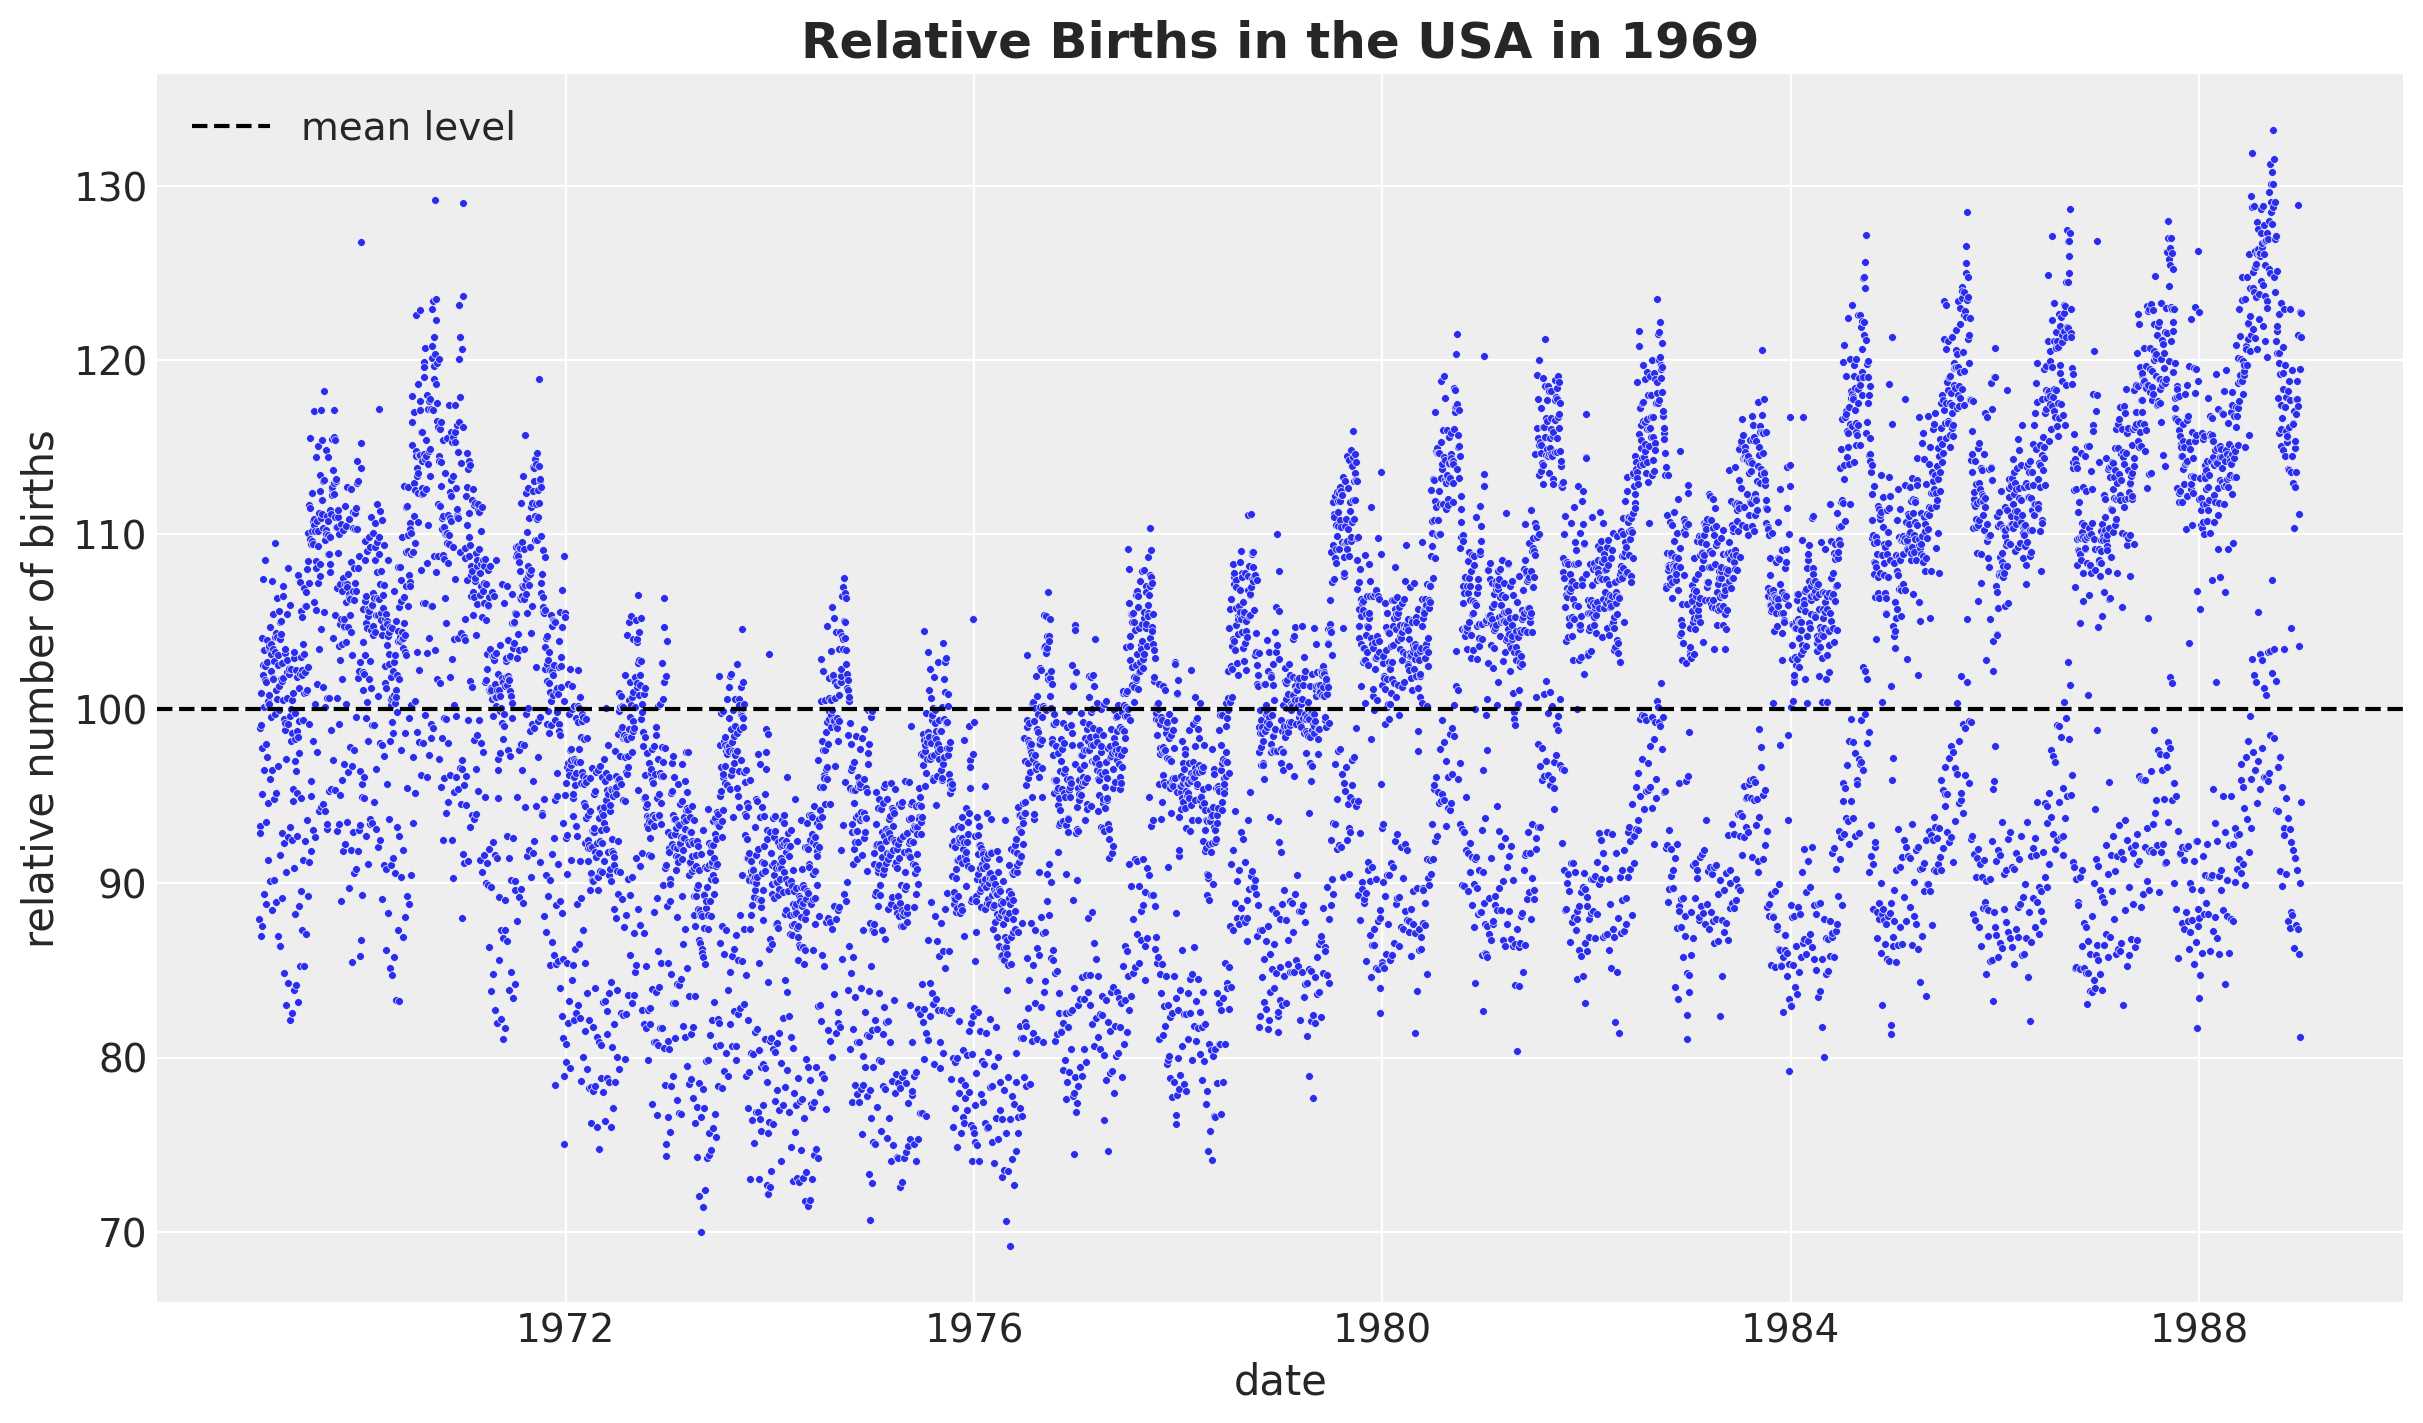

In [6]:
fig, ax = plt.subplots()
sns.scatterplot(data=data_df, x="date", y="births_relative100", c="C0", s=8, ax=ax)
ax.axhline(100, color="black", linestyle="--", label="mean level")
ax.legend()
ax.set(xlabel="date", ylabel="relative number of births")
ax.set_title(label="Relative Births in the USA in 1969", fontsize=18, fontweight="bold")

[Text(0.5, 0, 'day of year'),
 Text(0, 0.5, 'relative number of births per day of year')]

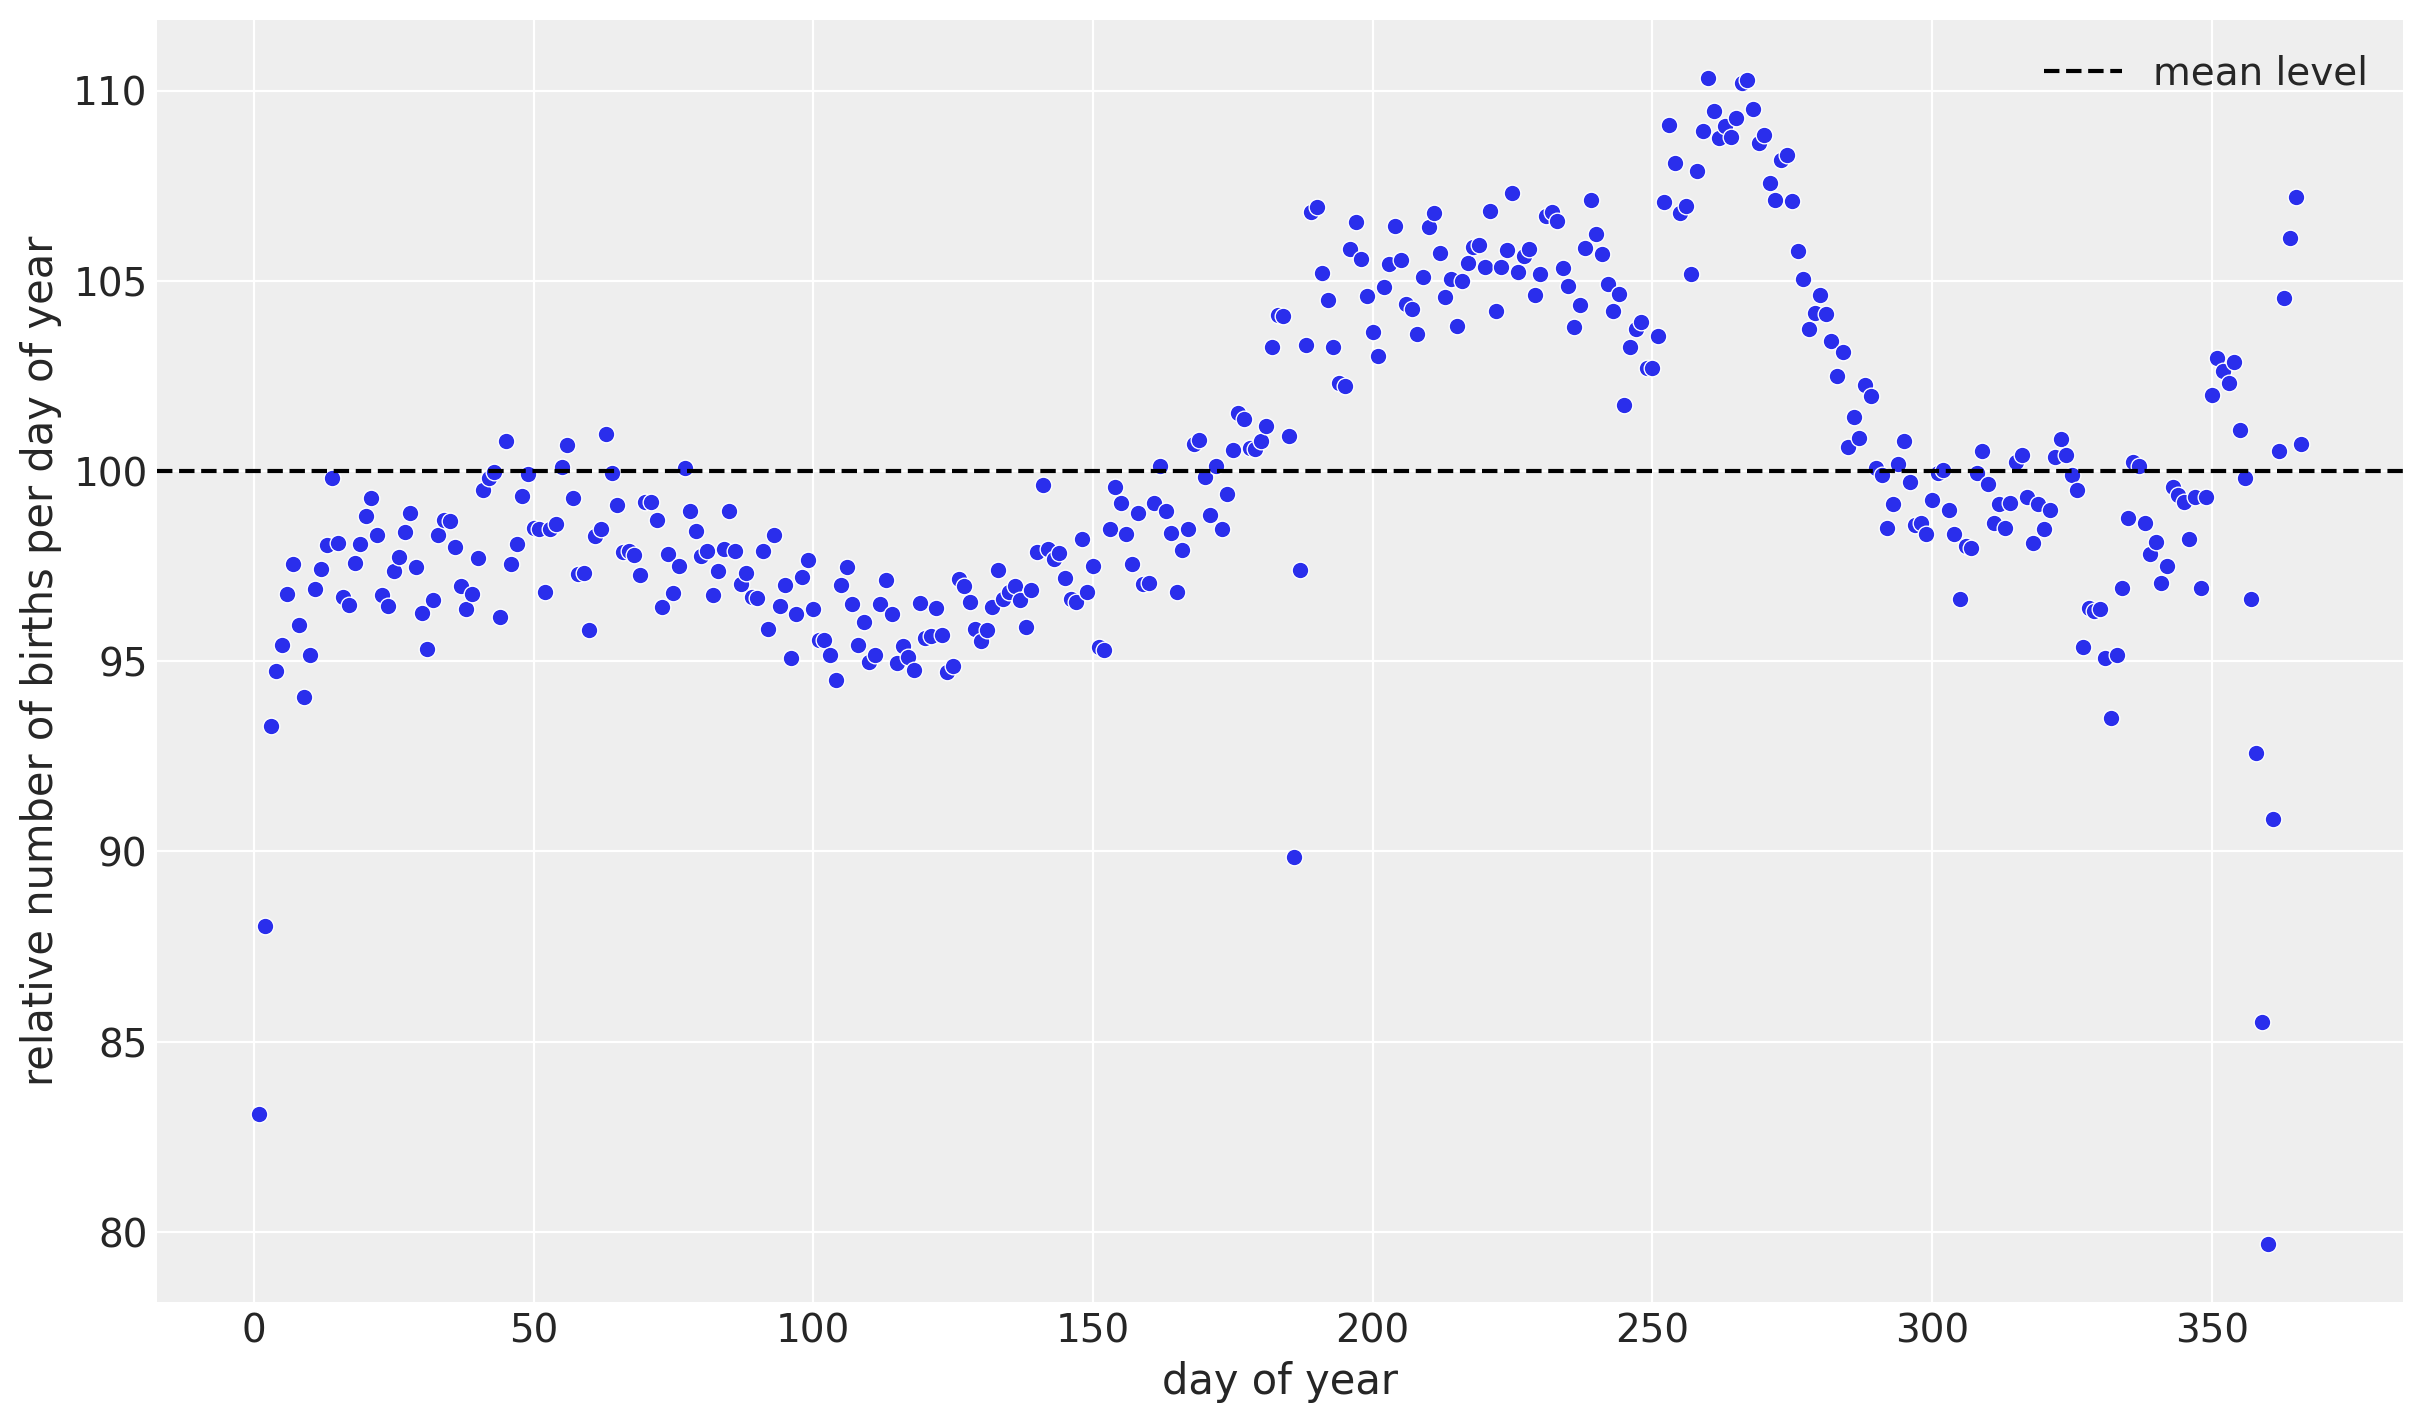

In [7]:
fig, ax = plt.subplots()
(
    data_df.groupby(["day_of_year2"], as_index=False)
    .agg(meanbirths=("births_relative100", "mean"))
    .pipe((sns.scatterplot, "data"), x="day_of_year2", y="meanbirths", c="C0", ax=ax)
)
ax.axhline(100, color="black", linestyle="--", label="mean level")
ax.legend()
ax.set(xlabel="day of year", ylabel="relative number of births per day of year")

[Text(0.5, 0, 'day of week'),
 Text(0, 0.5, 'relative number of births per day of week')]

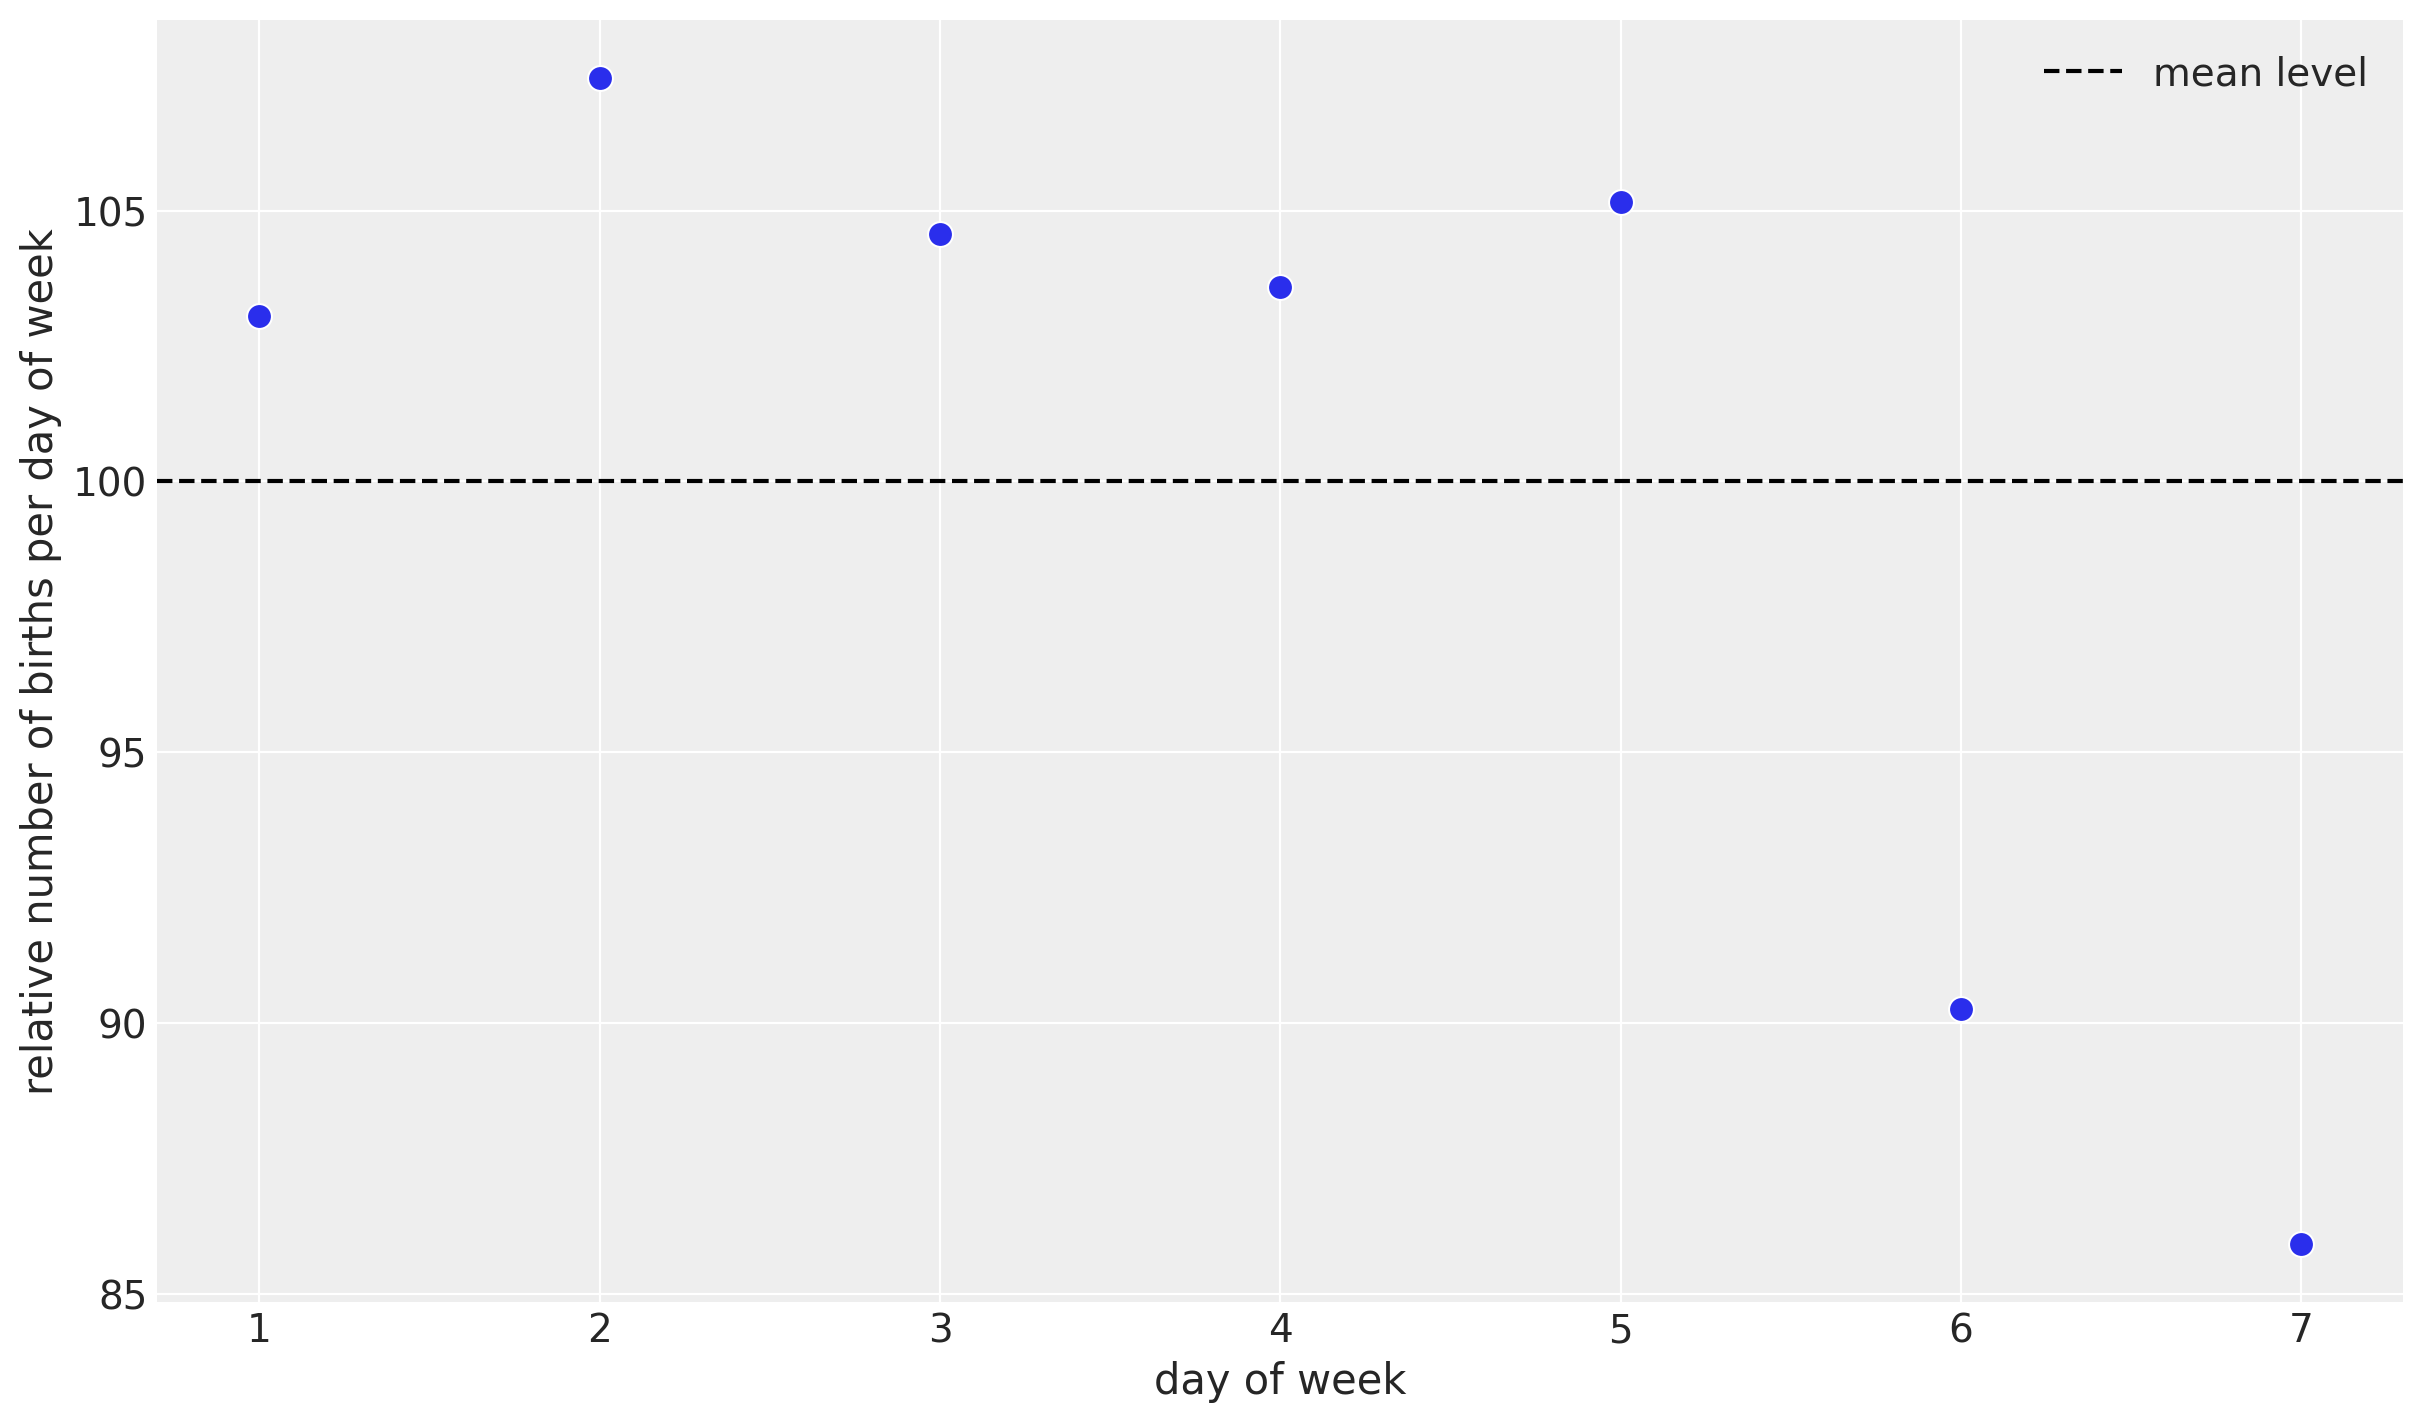

In [8]:
fig, ax = plt.subplots()
(
    data_df.groupby(["day_of_week"], as_index=False)
    .agg(meanbirths=("births_relative100", "mean"))
    .pipe(
        (sns.scatterplot, "data"), x="day_of_week", y="meanbirths", c="C0", s=80, ax=ax
    )
)
ax.axhline(100, color="black", linestyle="--", label="mean level")
ax.legend()
ax.set(xlabel="day of week", ylabel="relative number of births per day of week")

In [9]:
n = data_df.shape[0]
obs = data_df["obs"].to_numpy()
date = data_df["date"].to_numpy()
year = data_df["year"].to_numpy()
day_of_week_idx, day_of_week = data_df["day_of_week"].factorize(sort=True)
day_of_year2_idx, day_of_year2 = data_df["day_of_year2"].factorize(sort=True)
memorial_days = data_df["is_memorial_day"].to_numpy()
labor_days = data_df["is_labor_day"].to_numpy()
thanksgiving_days = data_df["is_thanksgiving_day"].to_numpy()
births_relative100 = data_df["births_relative100"].to_numpy()

In [10]:
obs_pipeline = Pipeline(steps=[("scaler", StandardScaler())])

obs_pipeline.fit(obs.reshape(-1, 1))
normalized_obs = obs_pipeline.transform(obs.reshape(-1, 1))

obs_std = obs_pipeline["scaler"].scale_.item()

births_relative100_pipeline = Pipeline(
    steps=[
        ("log", FunctionTransformer(func=np.log, inverse_func=np.exp)),
        ("scaler", StandardScaler()),
    ]
)

births_relative100_pipeline.fit(births_relative100.reshape(-1, 1))
normalized_log_births_relative100 = births_relative100_pipeline.transform(
    births_relative100.reshape(-1, 1)
)
normalized_log_births_relative100_std = births_relative100_pipeline[
    "scaler"
].scale_.item()

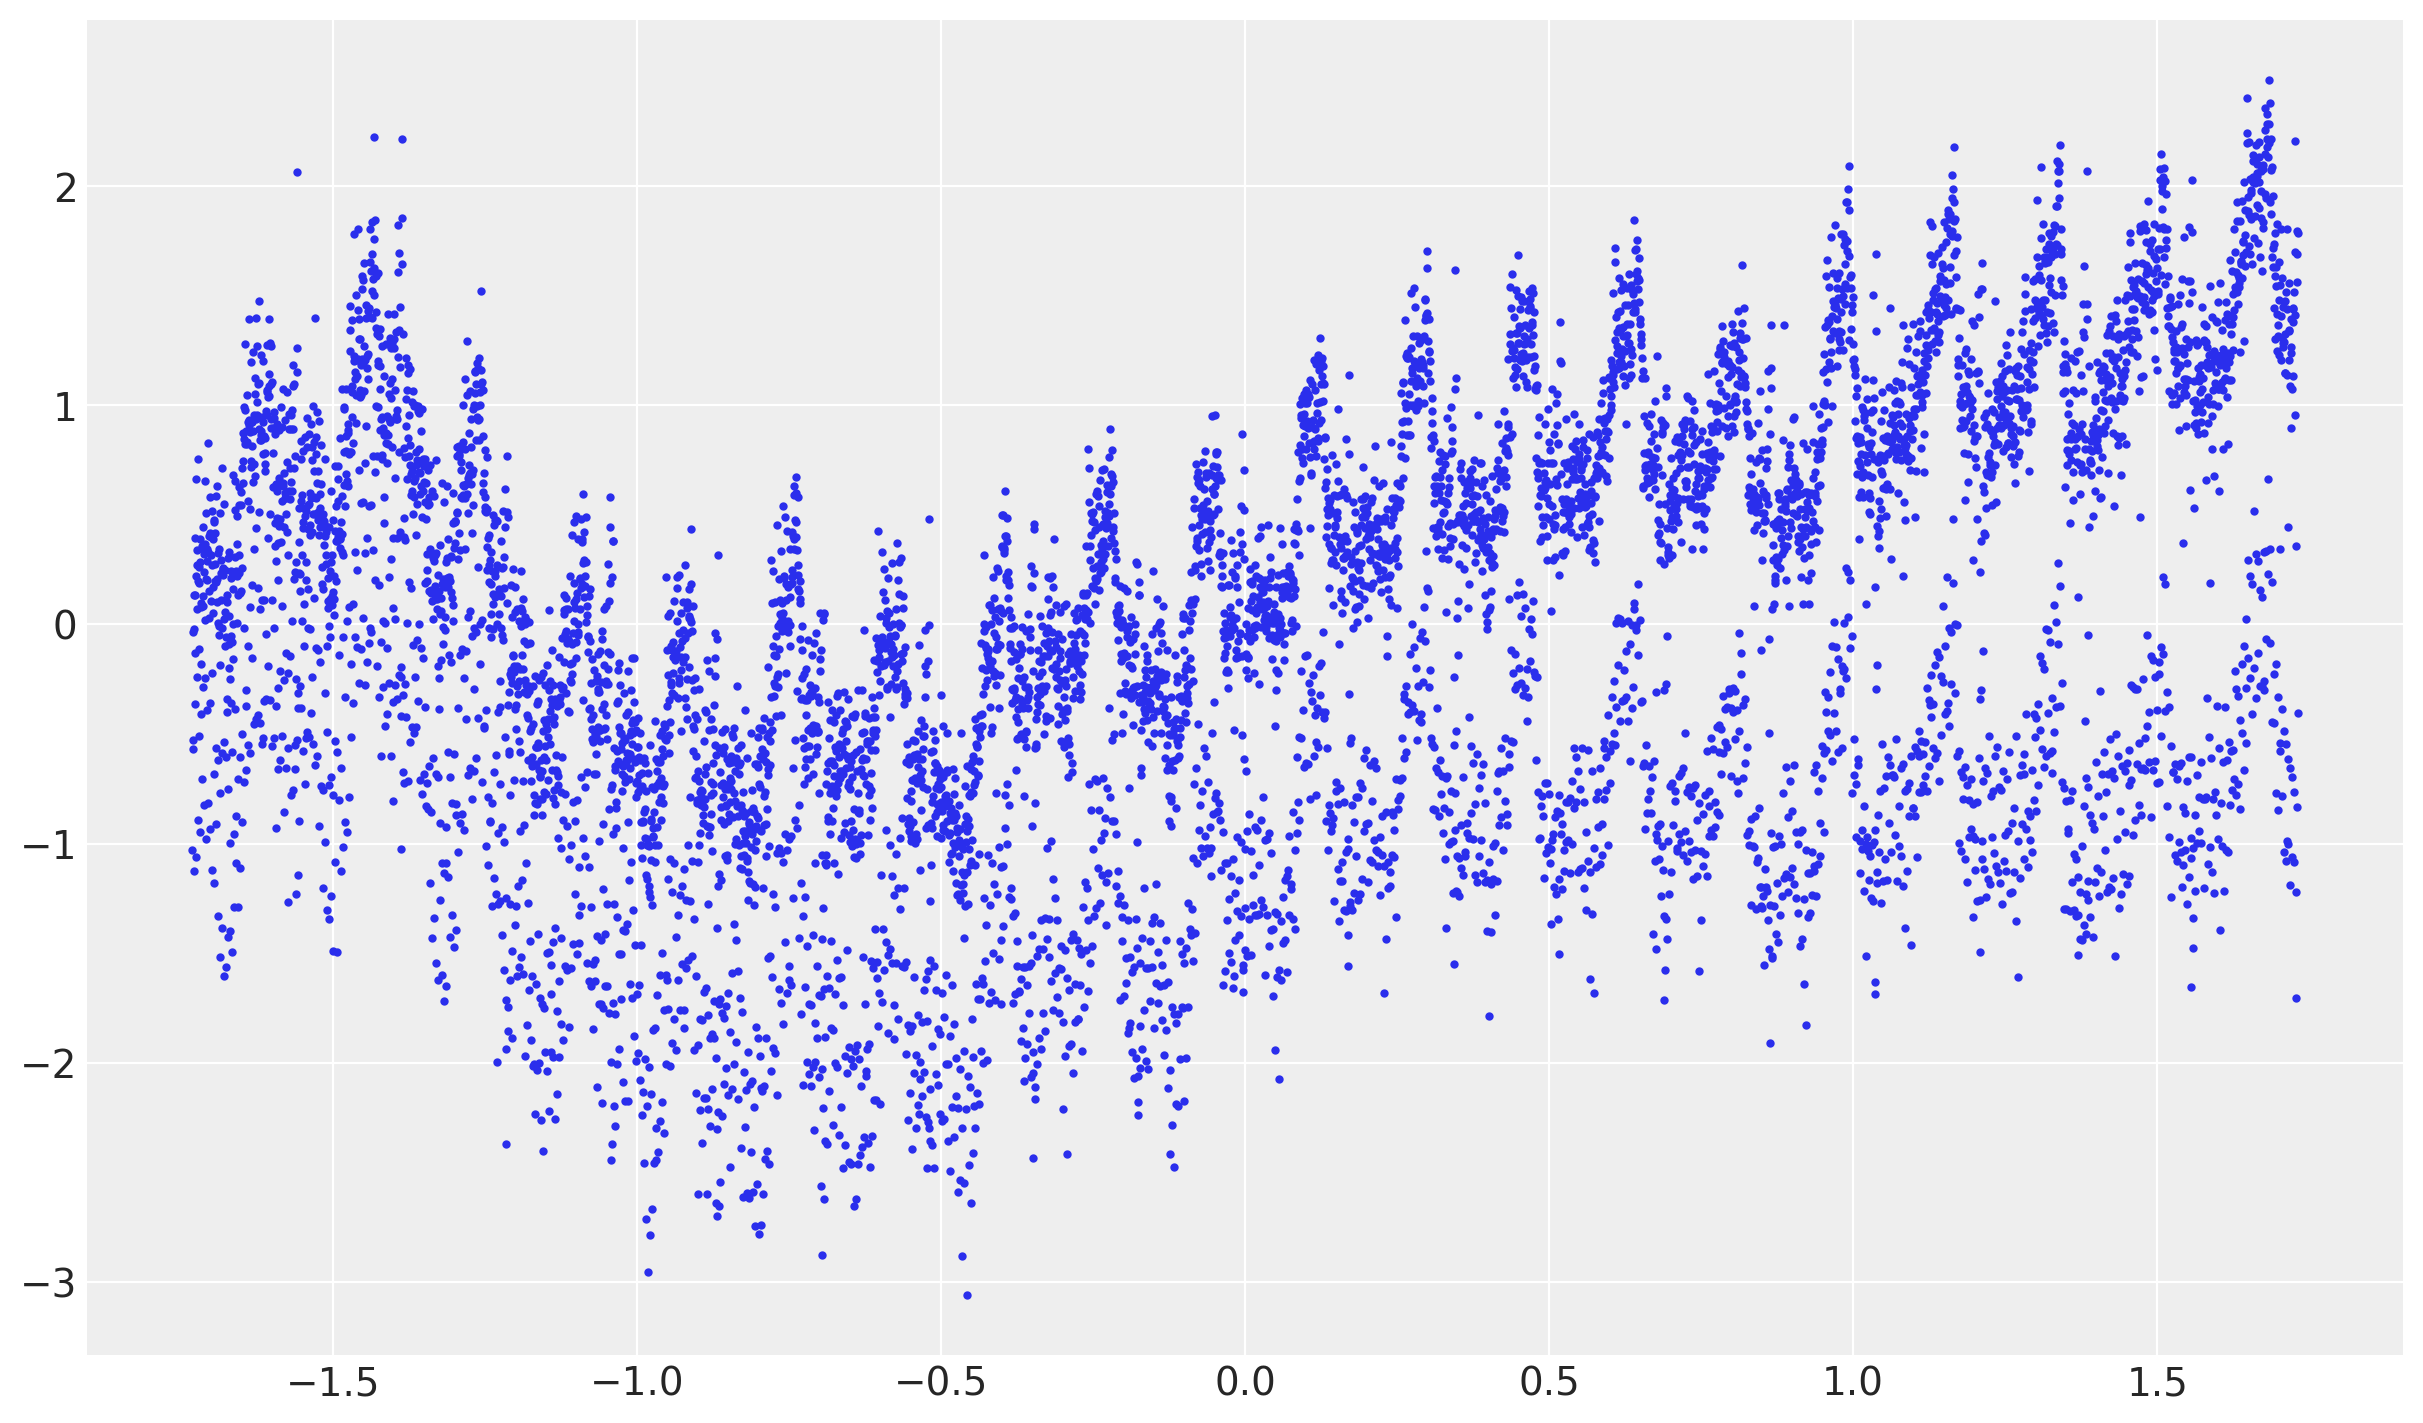

In [11]:
plt.plot(normalized_obs, normalized_log_births_relative100, "o", c="C0", markersize=2)

In [12]:
obs_std = obs.std()
normalized_obs = (obs - obs.mean()) / obs.std()


log_births_relative100 = np.log(births_relative100)
normalized_log_births_relative100 = (
    log_births_relative100 - log_births_relative100.mean()
) / log_births_relative100.std()

<Axes: >

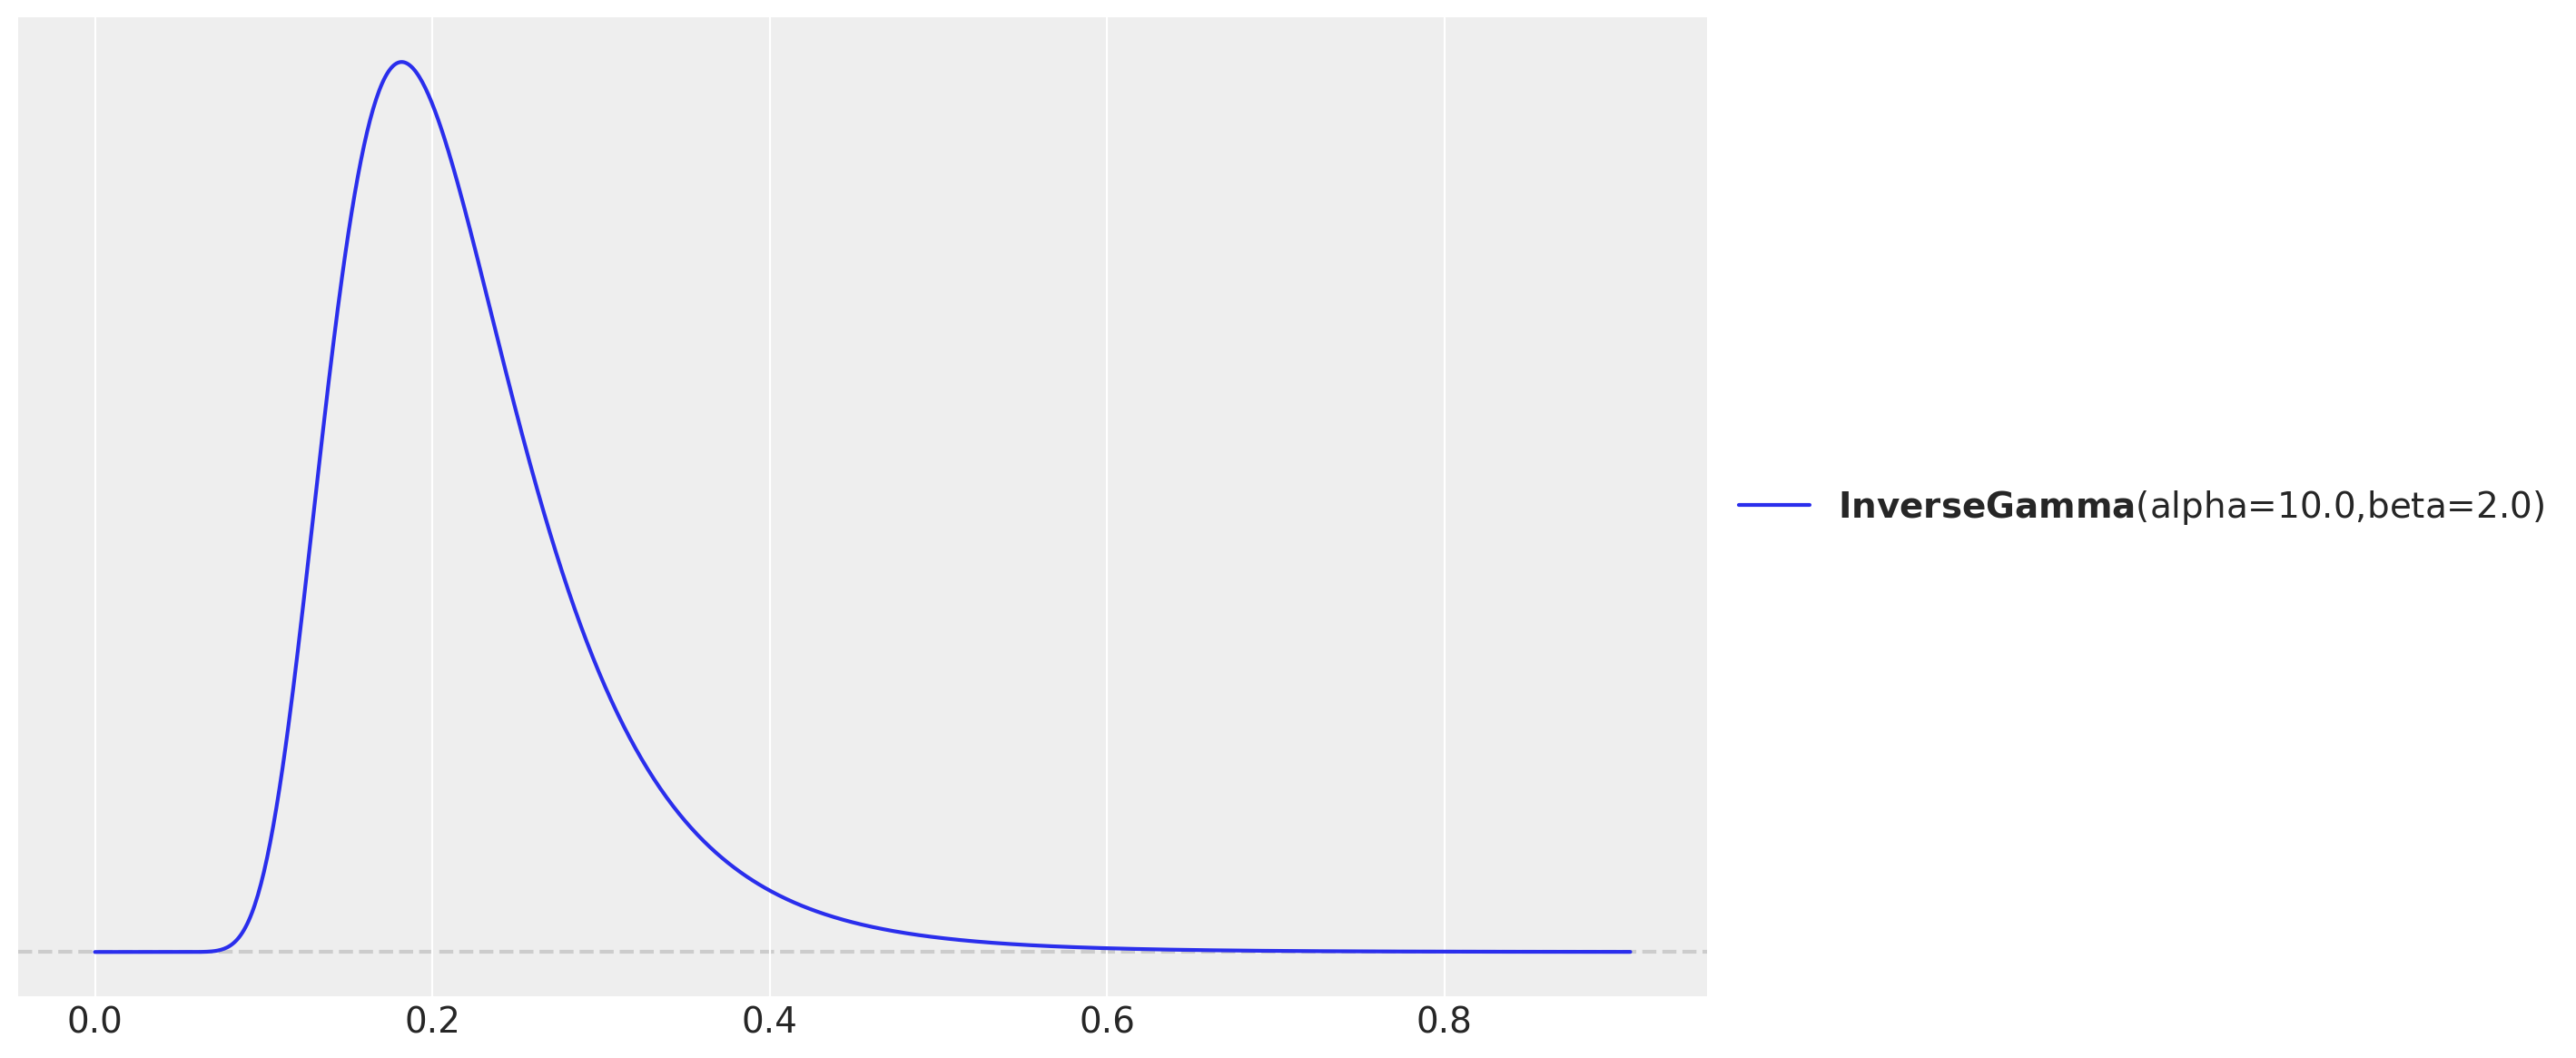

In [13]:
pz.InverseGamma(alpha=10, beta=2).plot_pdf()

<Axes: >

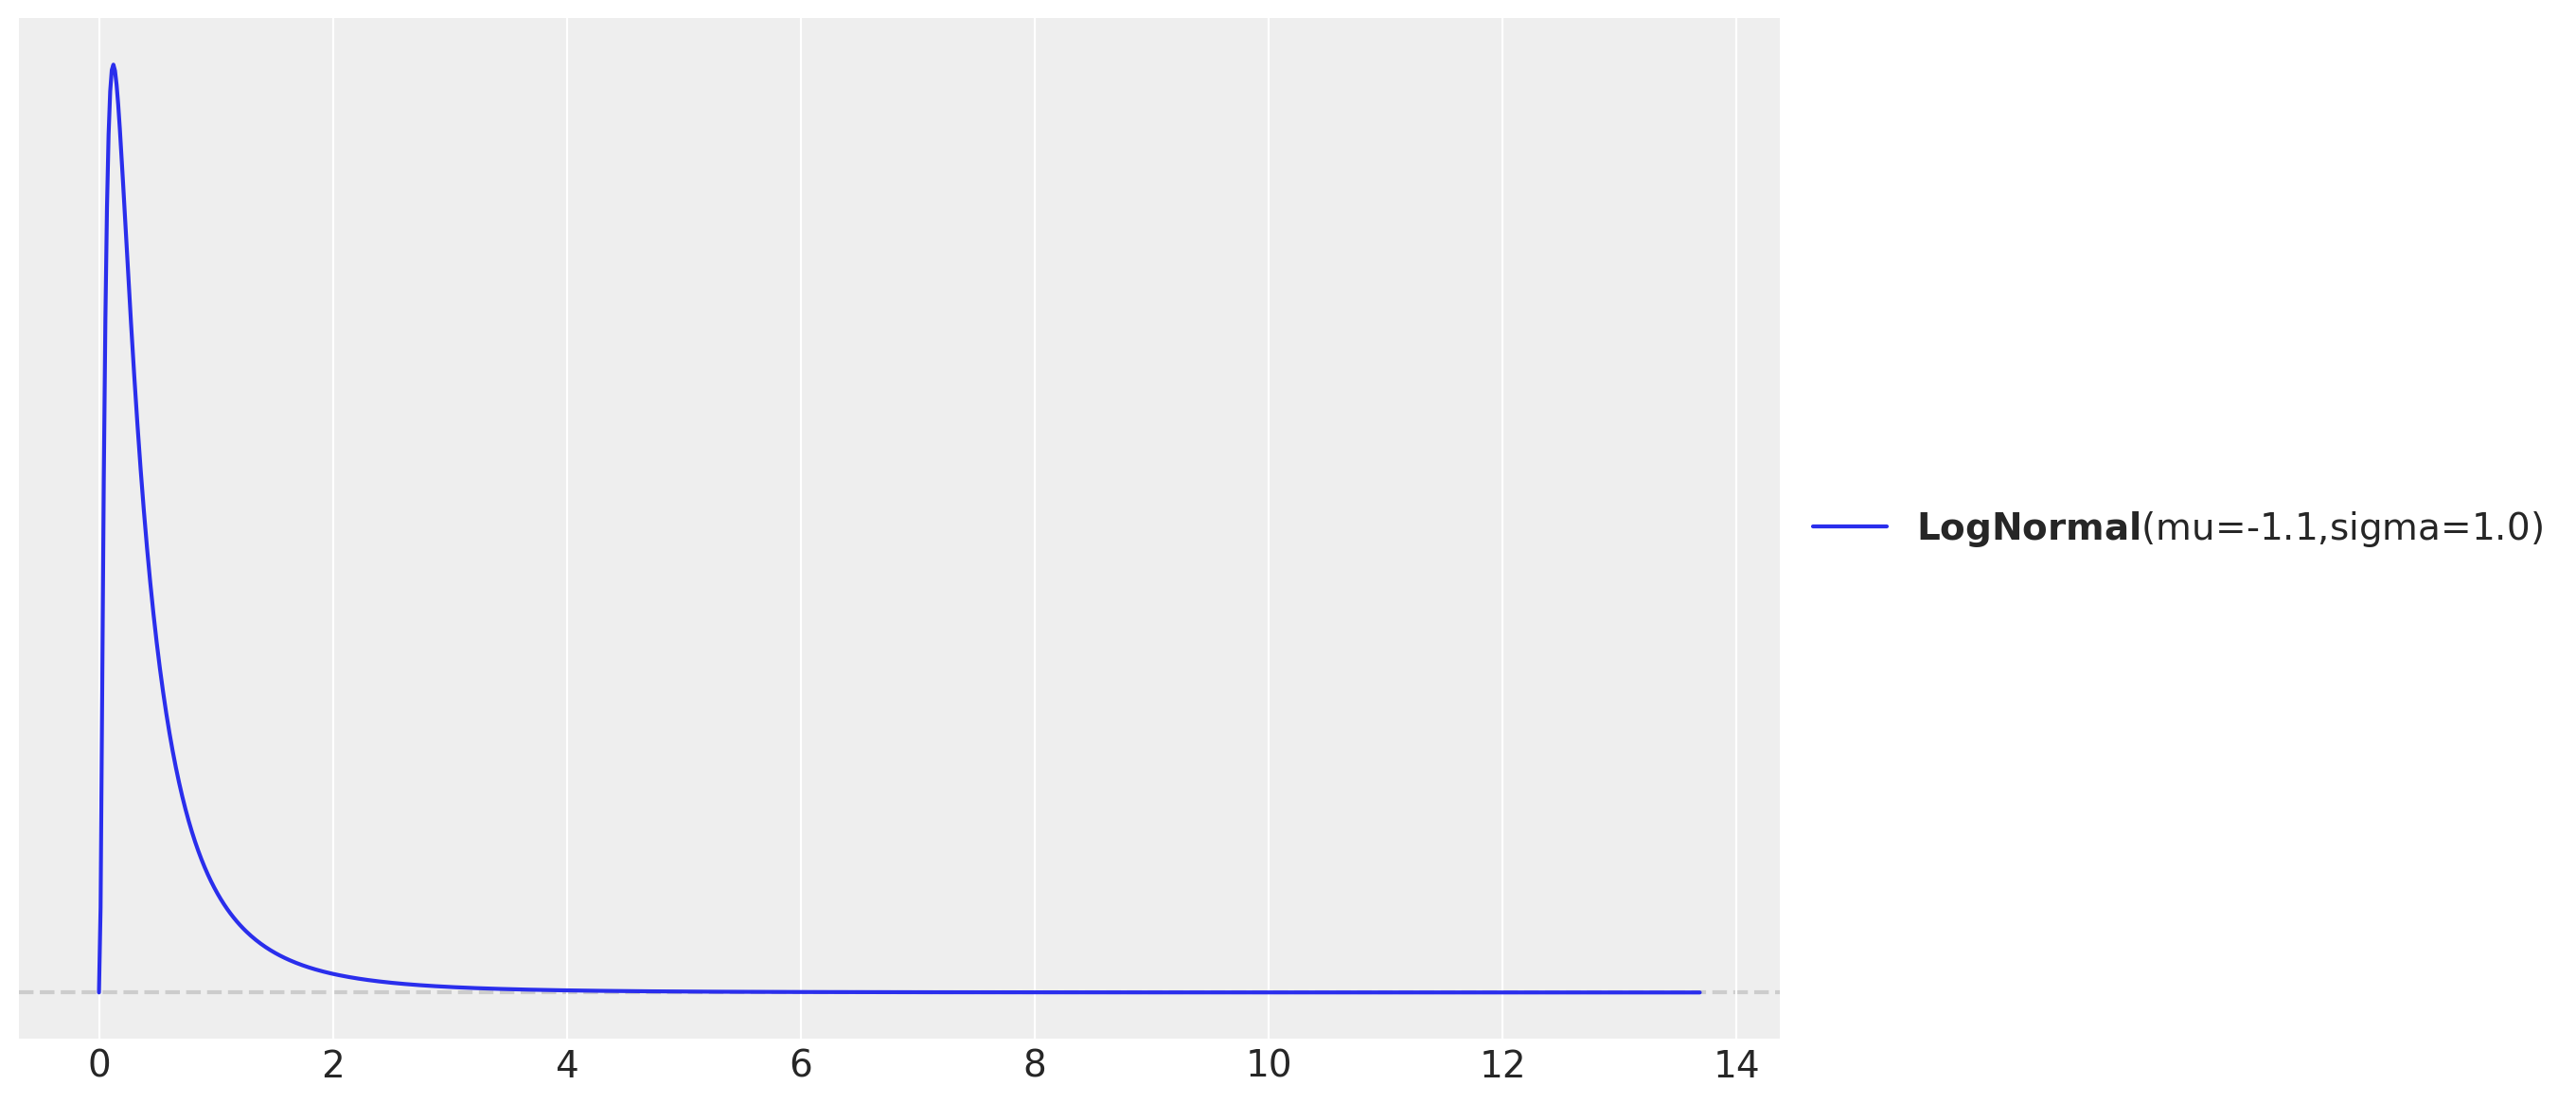

In [14]:
pz.LogNormal(mu=np.log(700 / obs_std), sigma=1).plot_pdf()

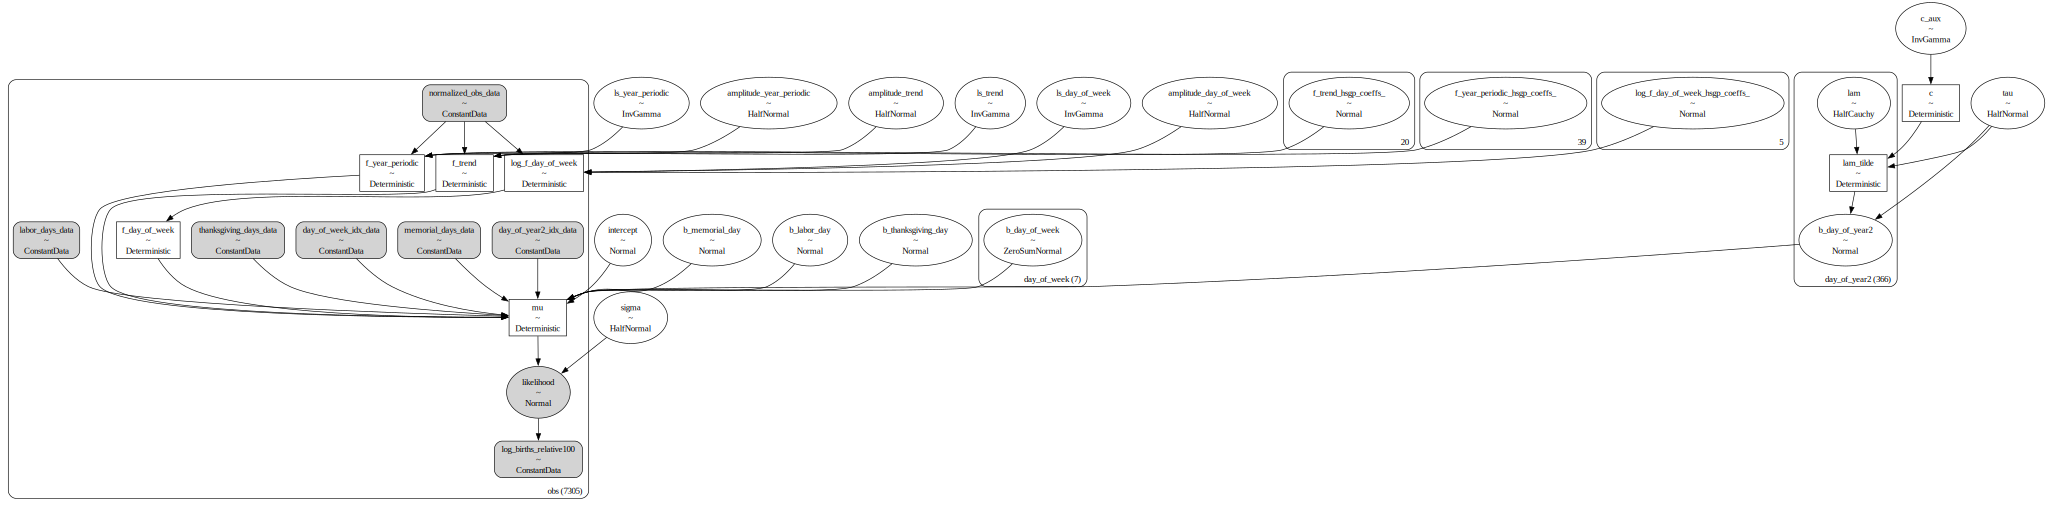

In [16]:
coords = {"obs": obs, "day_of_week": day_of_week, "day_of_year2": day_of_year2}

with pm.Model(coords=coords) as model:
    # --- Data Containers ---

    normalized_obs_data = pm.Data(
        name="normalized_obs_data", value=normalized_obs, mutable=False, dims="obs"
    )

    day_of_week_idx_data = pm.Data(
        name="day_of_week_idx_data", value=day_of_week_idx, mutable=False, dims="obs"
    )

    day_of_year2_idx_data = pm.Data(
        name="day_of_year2_idx_data", value=day_of_year2_idx, mutable=False, dims="obs"
    )

    memorial_days_data = pm.Data(
        name="memorial_days_data", value=memorial_days, mutable=False, dims="obs"
    )

    labor_days_data = pm.Data(
        name="labor_days_data", value=labor_days, mutable=False, dims="obs"
    )

    thanksgiving_days_data = pm.Data(
        name="thanksgiving_days_data",
        value=thanksgiving_days,
        mutable=False,
        dims="obs",
    )

    normalized_log_births_relative100_data = pm.Data(
        name="log_births_relative100",
        value=normalized_log_births_relative100,
        mutable=False,
        dims="obs",
    )

    # --- Priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)

    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=1.0)
    ls_trend = pm.InverseGamma(name="ls_trend", alpha=10, beta=2)
    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_trend)
    gp_trend = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov_trend)
    f_trend = gp_trend.prior(name="f_trend", X=normalized_obs_data[:, None], dims="obs")

    amplitude_year_periodic = pm.HalfNormal(name="amplitude_year_periodic", sigma=1)
    ls_year_periodic = pm.InverseGamma(name="ls_year_periodic", alpha=10, beta=2)
    gp_year_periodic = pm.gp.HSGPPeriodic(
        m=20,
        scale=amplitude_year_periodic,
        cov_func=pm.gp.cov.Periodic(
            input_dim=1, period=365.25 / obs_std, ls=ls_year_periodic
        ),
    )
    f_year_periodic = gp_year_periodic.prior(
        name="f_year_periodic", X=normalized_obs_data[:, None], dims="obs"
    )

    amplitude_day_of_week = pm.HalfNormal(name="amplitude_day_of_week", sigma=1)
    ls_day_of_week = pm.InverseGamma(name="ls_day_of_week", alpha=10, beta=2)
    cov_day_of_week = amplitude_day_of_week * pm.gp.cov.ExpQuad(
        input_dim=1, ls=ls_day_of_week
    )
    gp_day_of_week = pm.gp.HSGP(m=[5], c=1.5, cov_func=cov_day_of_week)
    log_f_day_of_week = gp_day_of_week.prior(
        name="log_f_day_of_week", X=normalized_obs_data[:, None], dims="obs"
    )
    f_day_of_week = pm.Deterministic(
        name="f_day_of_week", var=pt.exp(log_f_day_of_week), dims="obs"
    )

    b_day_of_week = pm.ZeroSumNormal(name="b_day_of_week", sigma=1, dims="day_of_week")

    slab_df = 50
    slab_scale = 2
    scale_global = 0.1
    tau = pm.HalfNormal(name="tau", sigma=2 * scale_global)
    c_aux = pm.InverseGamma(name="c_aux", alpha=slab_df / 2, beta=slab_df / 2)
    c = pm.Deterministic(name="c", var=slab_scale * pt.sqrt(c_aux))
    lam = pm.HalfCauchy(name="lam", beta=1, dims="day_of_year2")

    lam_tilde = pm.Deterministic(
        name="lam_tilde",
        var=pt.sqrt(c) * lam / pt.sqrt(c + (tau * lam) ** 2),
        dims="day_of_year2",
    )

    b_day_of_year2 = pm.Normal(
        name="b_day_of_year2", mu=0, sigma=tau * lam_tilde, dims="day_of_year2"
    )

    b_memorial_day = pm.Normal(name="b_memorial_day", mu=0, sigma=1)
    b_labor_day = pm.Normal(name="b_labor_day", mu=0, sigma=1)
    b_thanksgiving_day = pm.Normal(name="b_thanksgiving_day", mu=0, sigma=1)

    sigma = pm.HalfNormal(name="sigma", sigma=0.5)

    # --- Parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=intercept
        + f_trend
        + f_year_periodic
        + f_day_of_week * b_day_of_week[day_of_week_idx_data]
        + b_day_of_year2[day_of_year2_idx_data]
        + b_memorial_day * memorial_days_data
        + b_labor_day * labor_days_data
        + b_thanksgiving_day * thanksgiving_days_data,
        dims="obs",
    )

    # --- Likelihood ---
    pm.Normal(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=normalized_log_births_relative100_data,
        dims="obs",
    )

pm.model_to_graphviz(model=model)

In [17]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=1_000, random_seed=rng)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Sampling: [amplitude_day_of_week, amplitude_trend, amplitude_year_periodic, b_day_of_week, b_day_of_year2, b_labor_day, b_memorial_day, b_thanksgiving_day, c_aux, f_trend_hsgp_coeffs_, f_year_periodic_hsgp_coeffs_, intercept, lam, likelihood, log_f_day_of_week_hsgp_coeffs_, ls_day_of_week, ls_trend, ls_year_periodic, sigma, tau]


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


Text(0.5, 1.0, 'Prior Predictive')

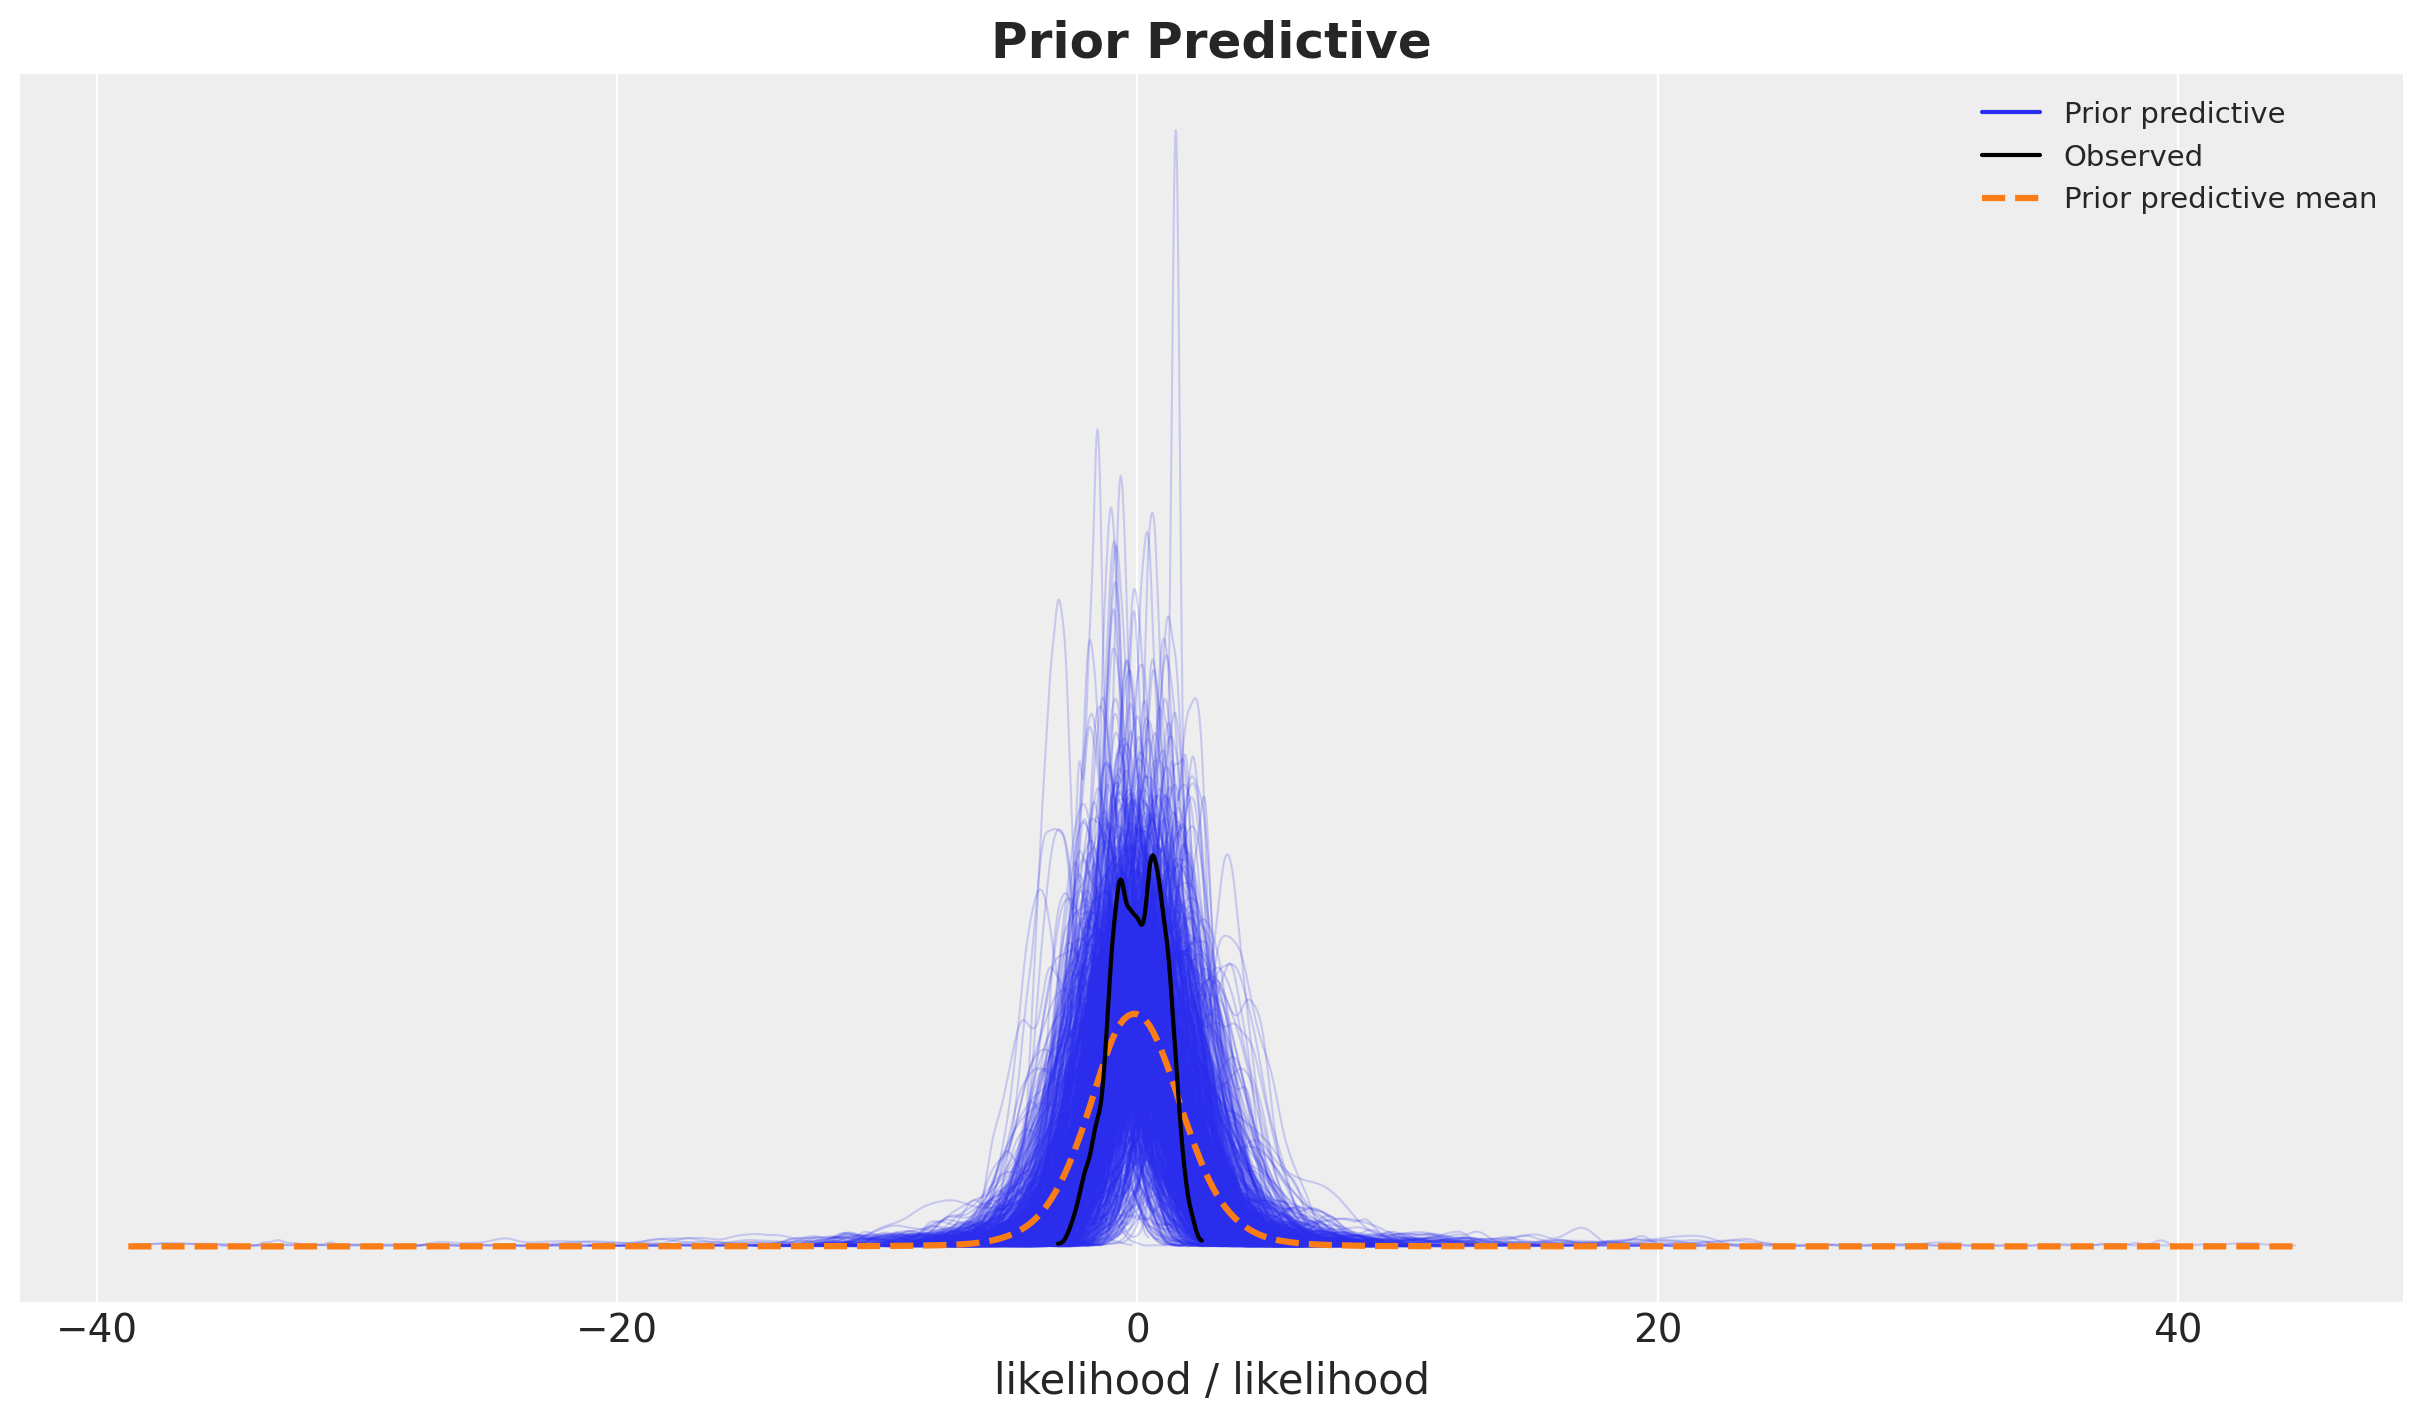

In [18]:
fig, ax = plt.subplots()
az.plot_ppc(data=prior_predictive, group="prior", kind="kde", ax=ax)
ax.set_title(label="Prior Predictive", fontsize=18, fontweight="bold")

In [19]:
with model:
    idata = pm.sample(
        tune=2_000,
        target_accept=0.97,
        draws=2_000,
        chains=4,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Compiling...
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time = 0:41:36.611575
Transforming variables...
Transformation time = 0:00:12.745601
Sampling: [likelihood]


In [20]:
idata["sample_stats"]["diverging"].sum().item()

31

In [21]:
var_names = [
    "intercept",
    "amplitude_trend",
    "ls_trend",
    "amplitude_year_periodic",
    "ls_year_periodic",
    "b_day_of_week",
    "b_memorial_day",
    "b_labor_day",
    "b_thanksgiving_day",
    "sigma",
]

az.summary(data=idata, var_names=var_names, round_to=3)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept                0.151  0.131  -0.018    0.421      0.047    0.034   
amplitude_trend          0.375  0.100   0.189    0.556      0.037    0.027   
ls_trend                 0.212  0.020   0.176    0.252      0.007    0.005   
amplitude_year_periodic  1.001  0.090   0.878    1.168      0.042    0.032   
ls_year_periodic         0.148  0.006   0.137    0.158      0.002    0.002   
b_day_of_week[1]         0.298  0.026   0.266    0.349      0.013    0.010   
b_day_of_week[2]         0.622  0.051   0.568    0.731      0.025    0.019   
b_day_of_week[3]         0.387  0.032   0.350    0.453      0.015    0.011   
b_day_of_week[4]         0.336  0.028   0.301    0.393      0.013    0.010   
b_day_of_week[5]         0.462  0.038   0.418    0.540      0.018    0.014   
b_day_of_week[6]        -0.852  0.069  -0.994   -0.779      0.034    0.026   
b_day_of_week[7]        -1.252  0.103  -1.461   -1.142      0.050    0.038   
b_memorial_day          -1.227  0.045  -1.307   -1.143      0.015    0.011   
b_labor_day             -0.905  0.035  -0.966   -0.842      0.014    0.010   
b_thanksgiving_day      -1.306  0.039  -1.375   -1.231      0.015    0.011   
sigma                    0.230  0.002   0.226    0.232      0.001    0.000   

                         ess_bulk  ess_tail  r_hat  
intercept                   9.177    22.059  1.409  
amplitude_trend             7.254    45.100  1.548  
ls_trend                    7.552    25.703  1.510  
amplitude_year_periodic     6.090    16.122  1.799  
ls_year_periodic            6.107    28.131  1.733  
b_day_of_week[1]            6.063    17.403  1.760  
b_day_of_week[2]            5.454    11.287  1.996  
b_day_of_week[3]            5.597    11.431  1.929  
b_day_of_week[4]            5.828    12.263  1.830  
b_day_of_week[5]            5.717    11.635  1.867  
b_day_of_week[6]            5.358    11.541  2.056  
b_day_of_week[7]            5.475    11.395  2.006  
b_memorial_day              8.620    58.143  1.426  
b_labor_day                 7.212    46.268  1.528  
b_thanksgiving_day          8.201    39.052  1.514  
sigma                       7.347    40.848  1.535

Text(0.5, 0.98, 'Trace')

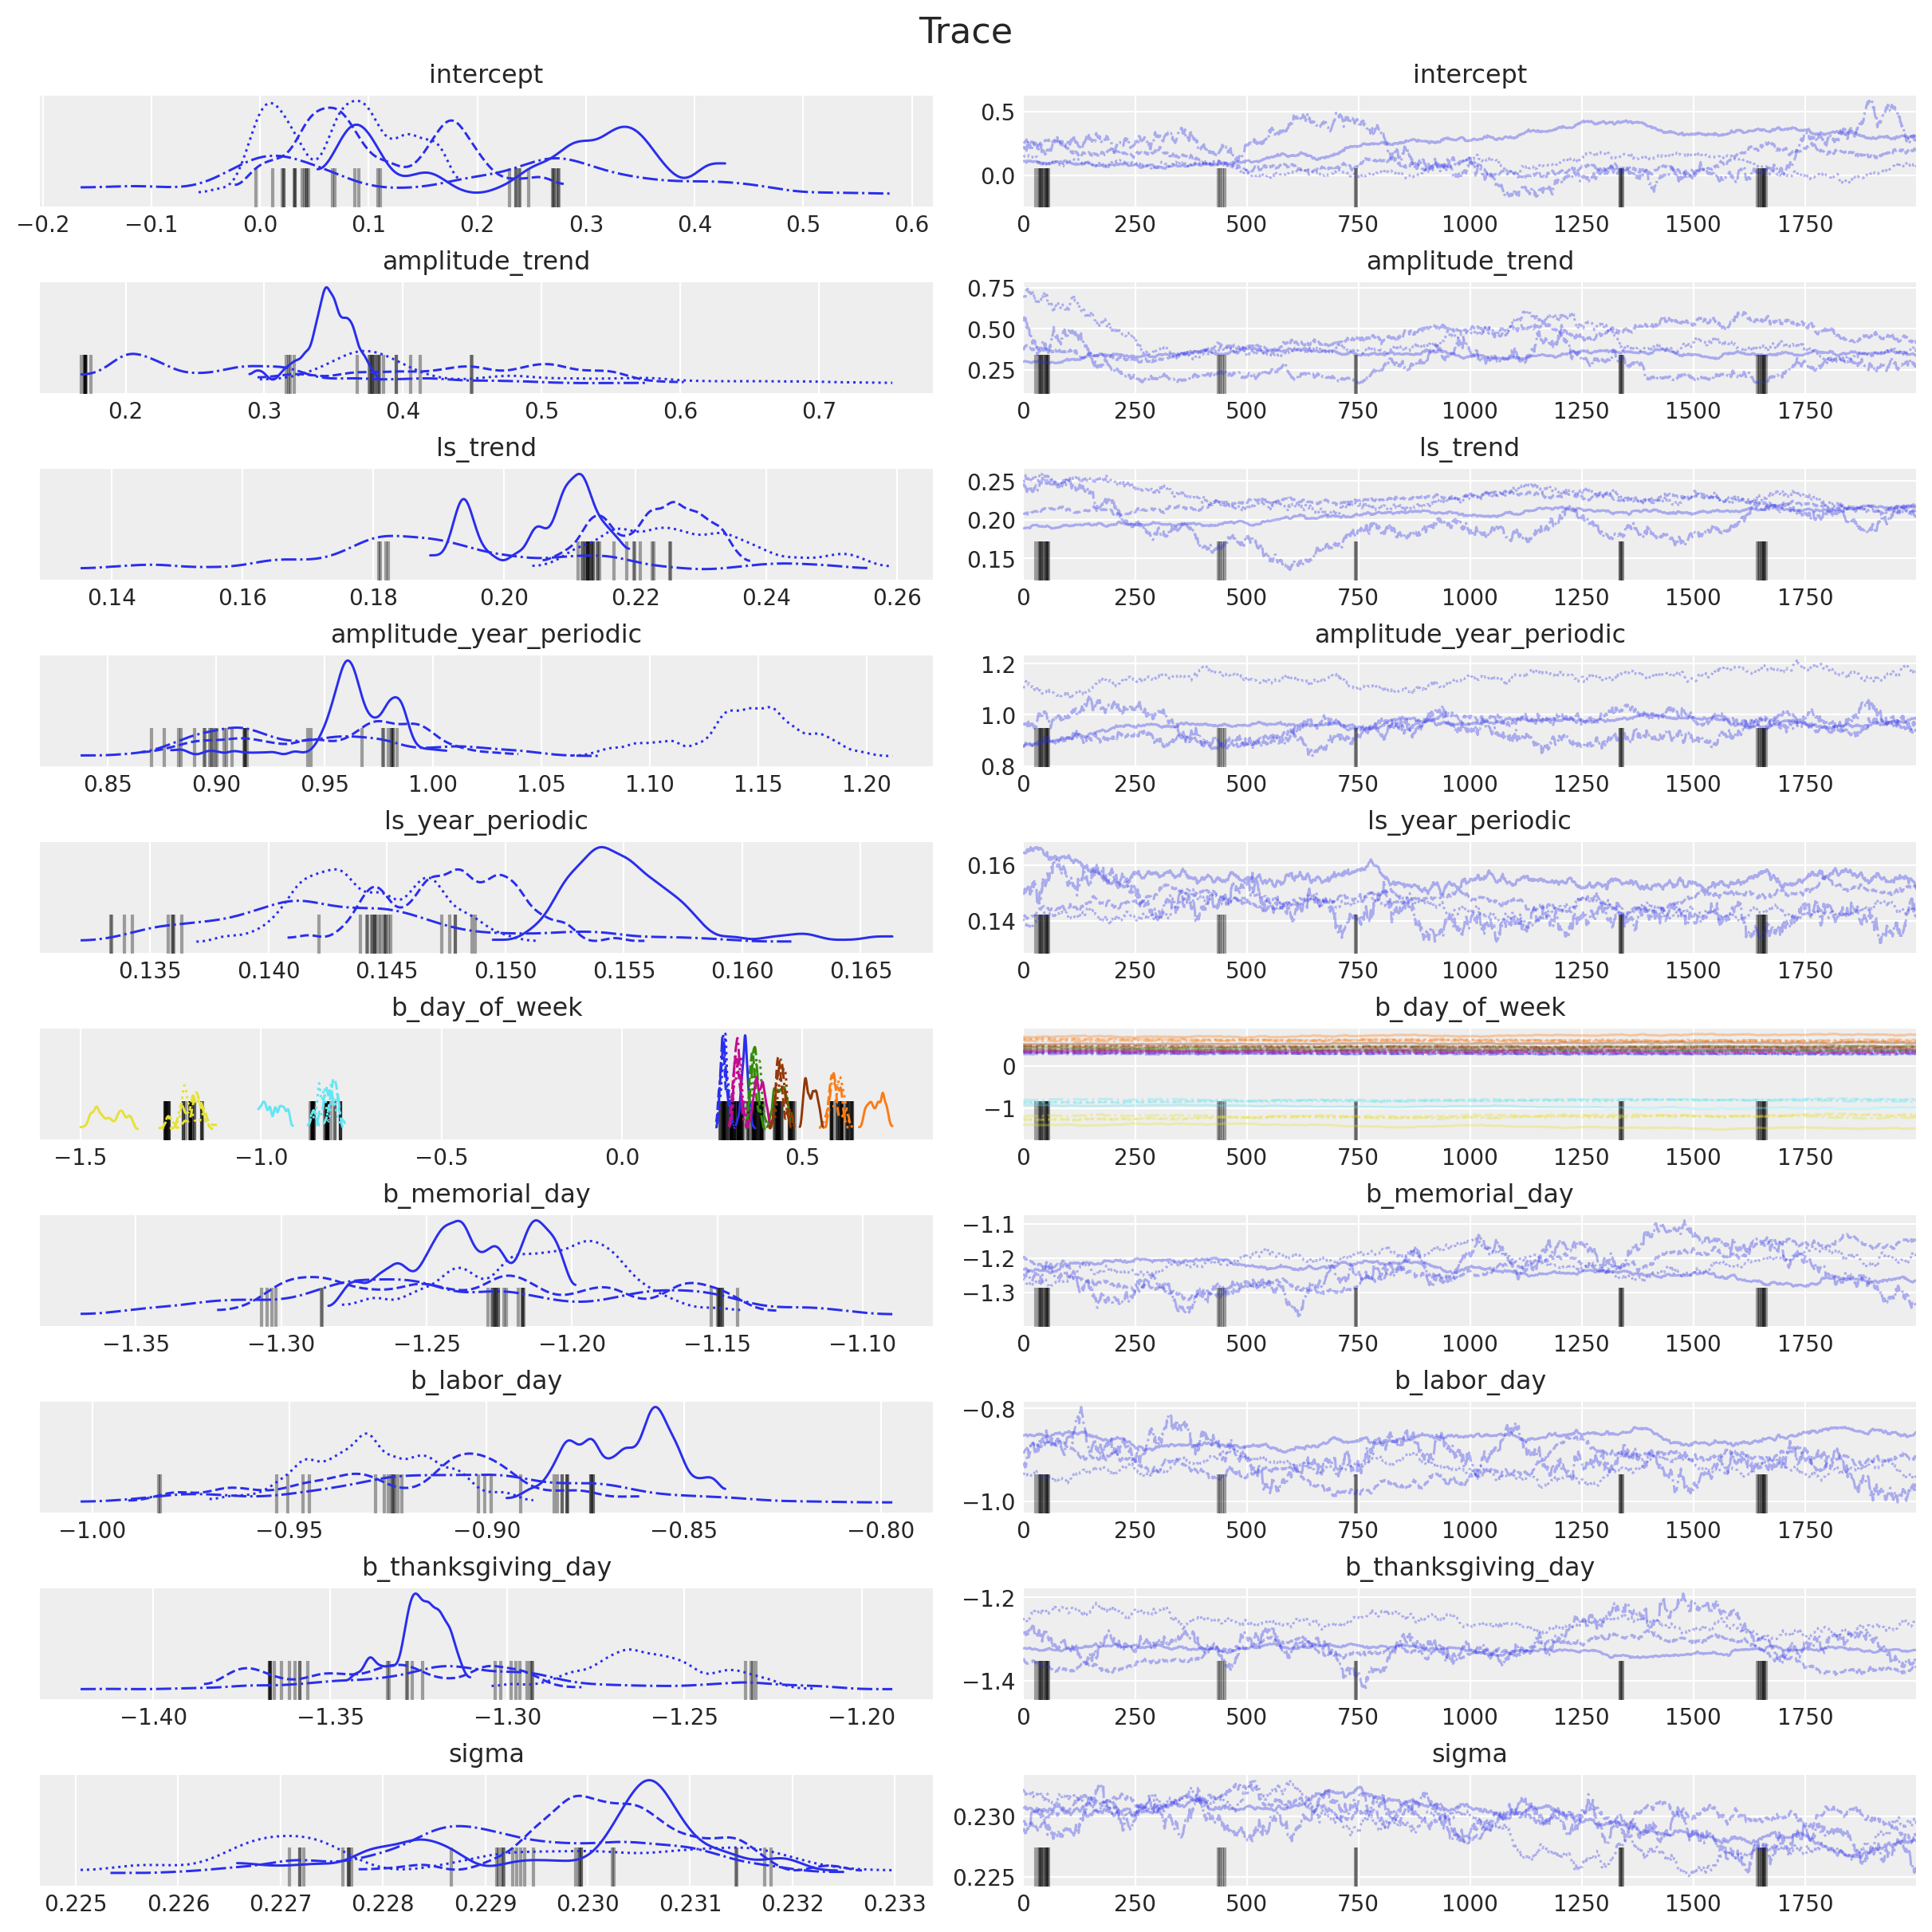

In [22]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (12, 12), "layout": "constrained"},
)
plt.gcf().suptitle("Trace", fontsize=16)

In [23]:
pp_vars_original_scale = {
    var_name: xr.apply_ufunc(
        births_relative100_pipeline.inverse_transform,
        idata["posterior"][var_name].expand_dims(dim={"_": 1}, axis=-1),
        input_core_dims=[["obs", "_"]],
        output_core_dims=[["obs", "_"]],
        vectorize=True,
    ).squeeze(dim="_")
    for var_name in ["mu", "f_trend", "f_year_periodic"]
}

In [24]:
pp_likelihood_original_scale = xr.apply_ufunc(
    births_relative100_pipeline.inverse_transform,
    posterior_predictive["posterior_predictive"]["likelihood"].expand_dims(
        dim={"_": 1}, axis=-1
    ),
    input_core_dims=[["obs", "_"]],
    output_core_dims=[["obs", "_"]],
    vectorize=True,
).squeeze(dim="_")

Text(0.5, 1.0, 'Relative Births in the USA in 1969\nPosterior Predictive')

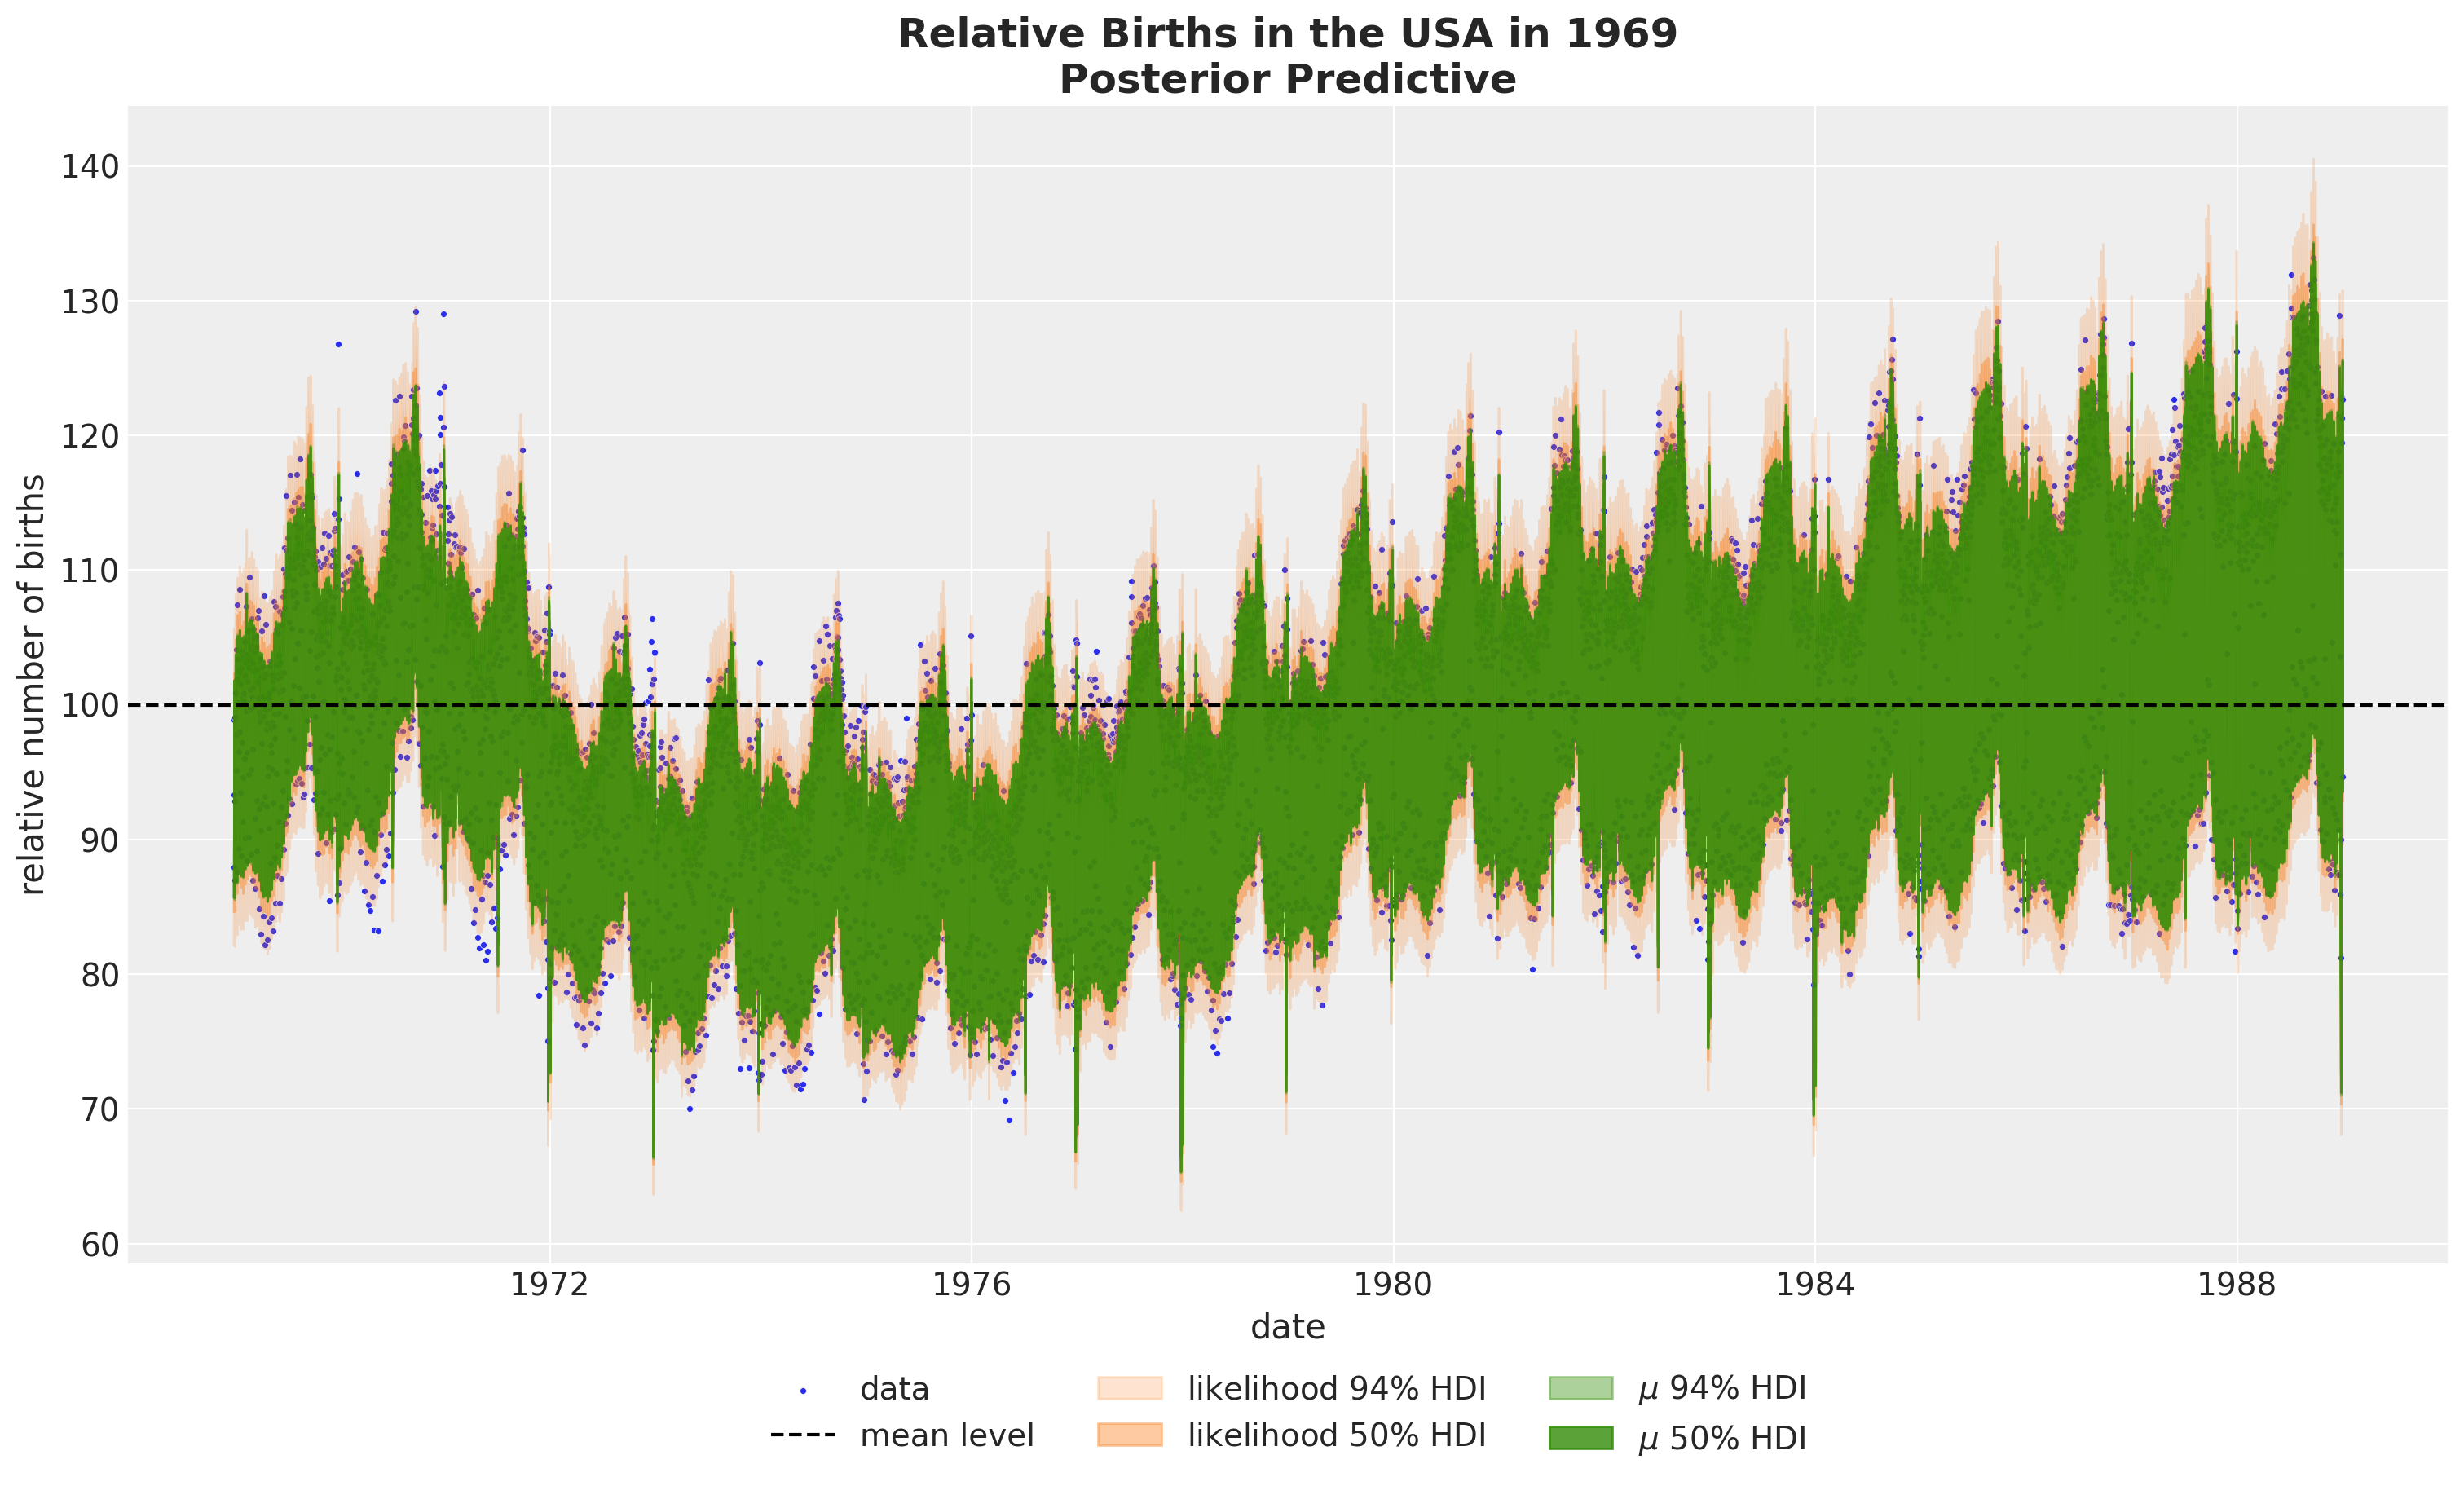

In [25]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.scatterplot(
    data=data_df, x="date", y="births_relative100", c="C0", s=8, label="data", ax=ax
)
ax.axhline(100, color="black", linestyle="--", label="mean level")
az.plot_hdi(
    x=date,
    y=pp_likelihood_original_scale,
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.2, "label": r"likelihood $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_likelihood_original_scale,
    hdi_prob=0.5,
    color="C1",
    fill_kwargs={"alpha": 0.4, "label": r"likelihood $50\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale["mu"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.4, "label": r"$\mu$ $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale["mu"],
    hdi_prob=0.9,
    color="C2",
    fill_kwargs={"alpha": 0.8, "label": r"$\mu$ $50\%$ HDI"},
    smooth=False,
    ax=ax,
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.07), ncol=3)
ax.set(xlabel="date", ylabel="relative number of births")
ax.set_title(
    label="Relative Births in the USA in 1969\nPosterior Predictive",
    fontsize=18,
    fontweight="bold",
)

In [26]:
pp_b_day_of_year2_original_scale = xr.apply_ufunc(
    births_relative100_pipeline.inverse_transform,
    idata["posterior"]["b_day_of_year2"].expand_dims(dim={"_": 1}, axis=-1),
    input_core_dims=[["day_of_year2", "_"]],
    output_core_dims=[["day_of_year2", "_"]],
    vectorize=True,
).squeeze(dim="_")

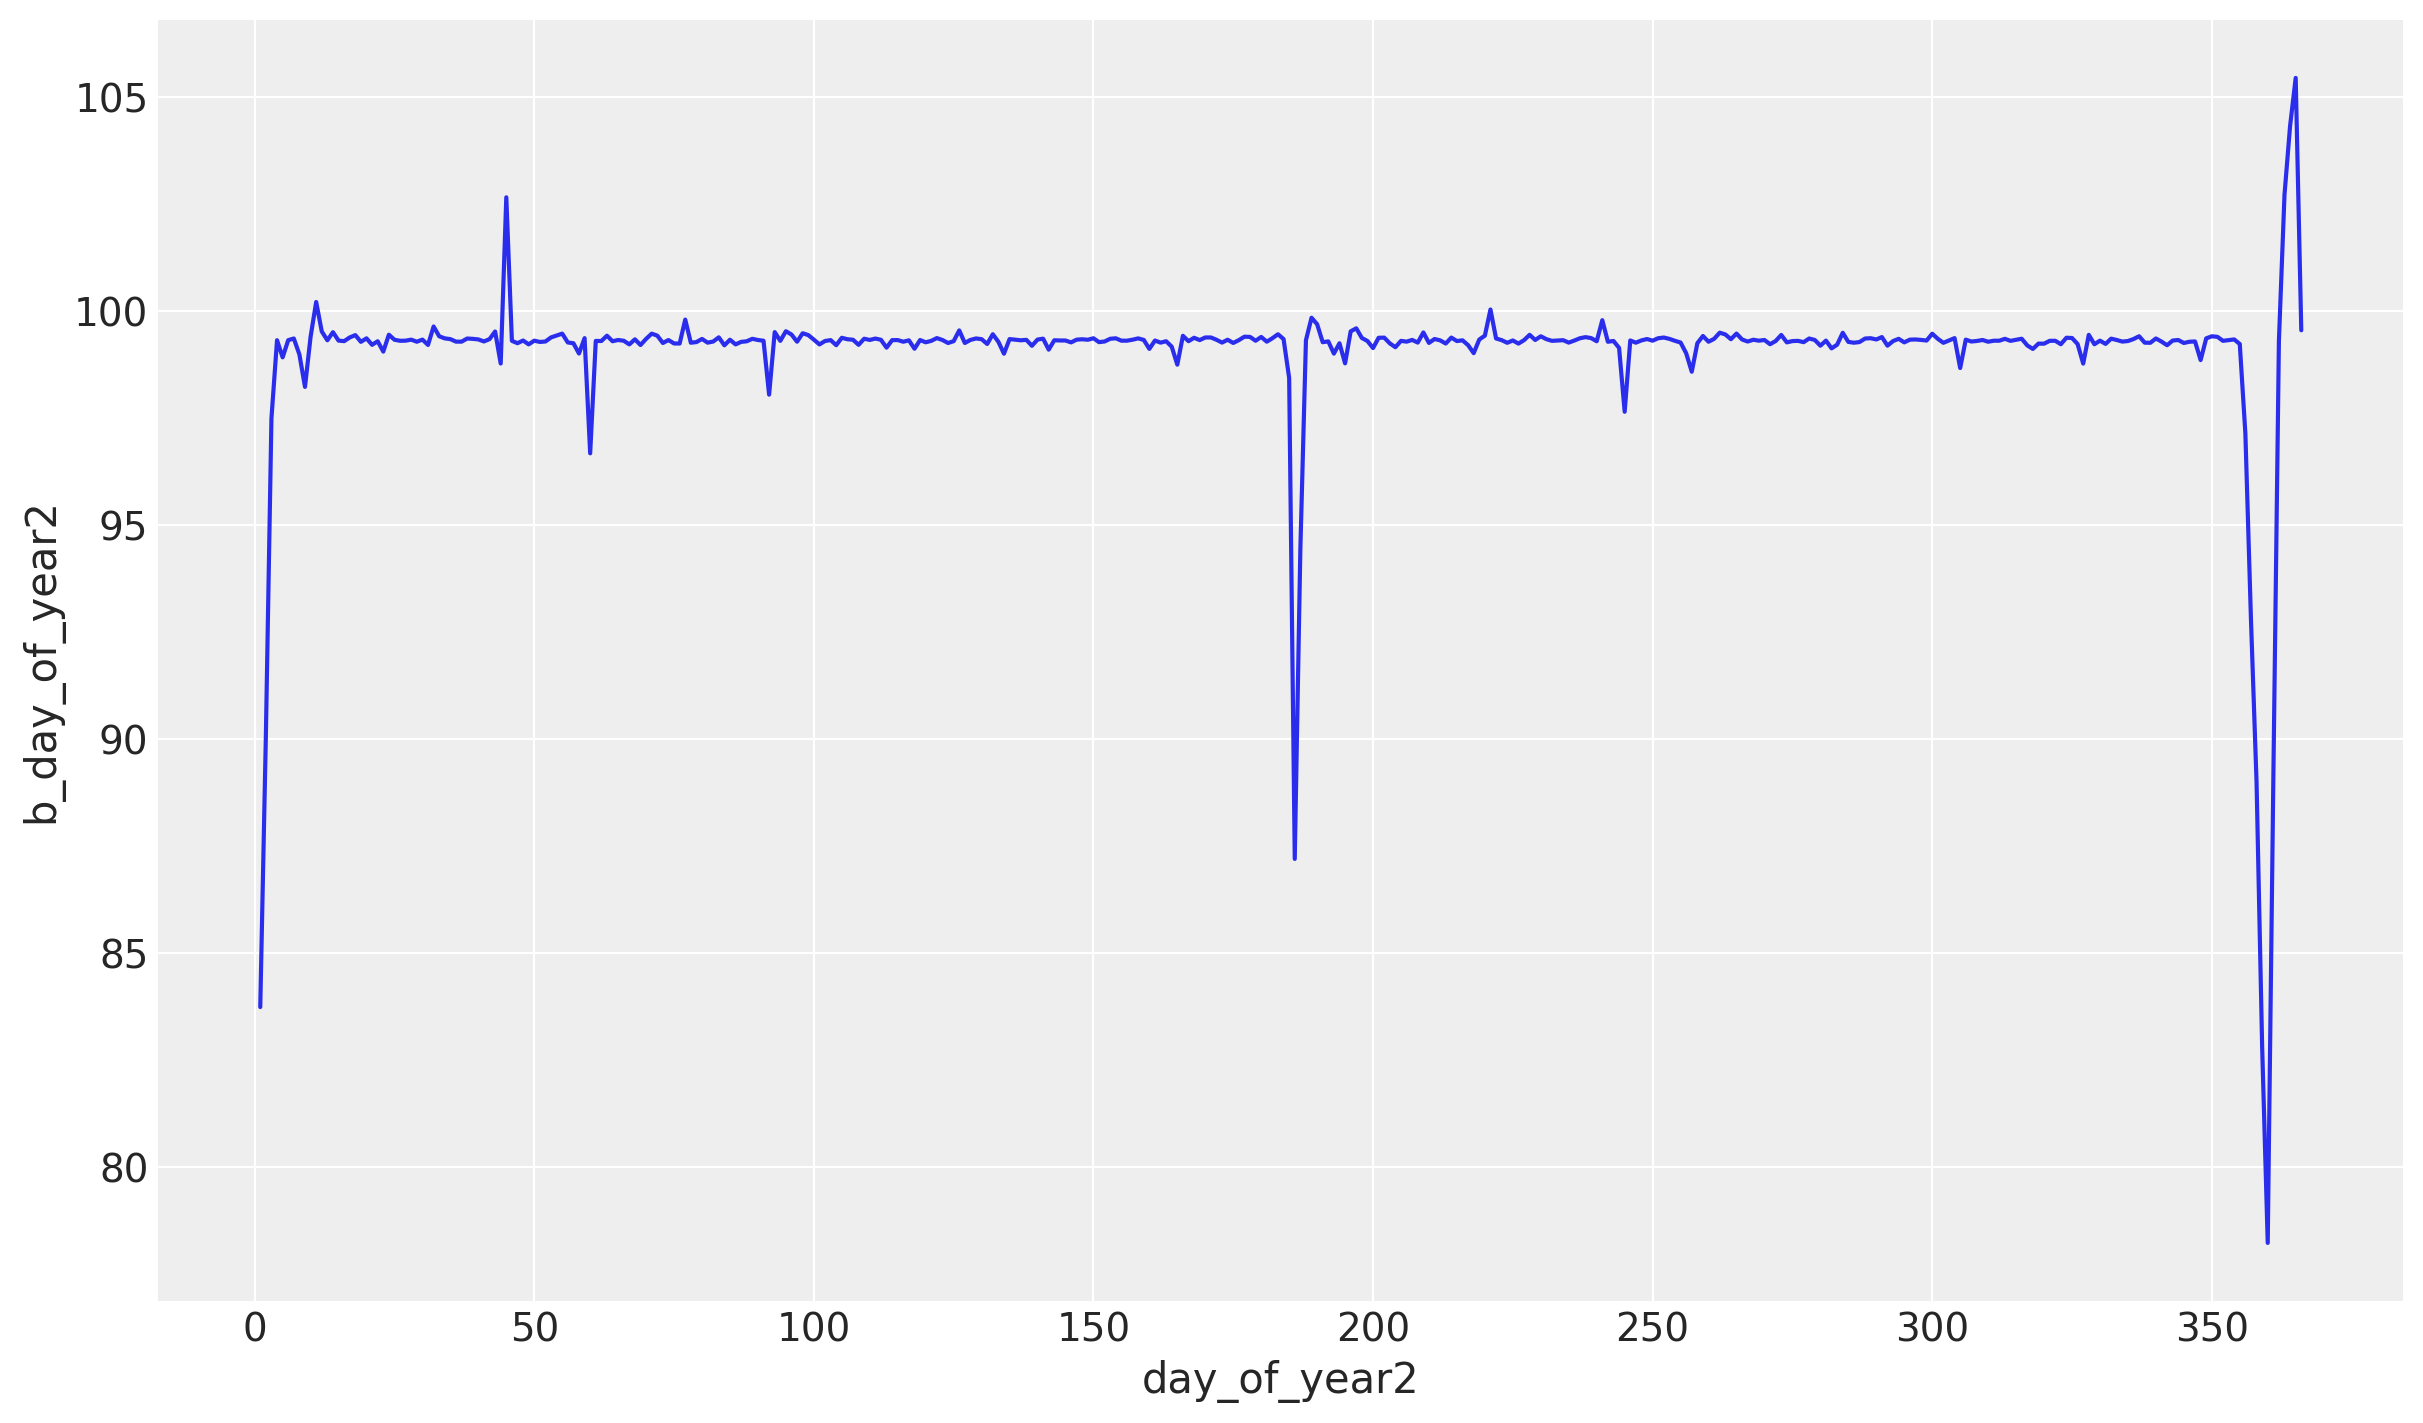

In [27]:
pp_b_day_of_year2_original_scale.mean(dim=("chain", "draw")).plot()

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


Text(0.5, 1.0, 'Posterior Predictive')

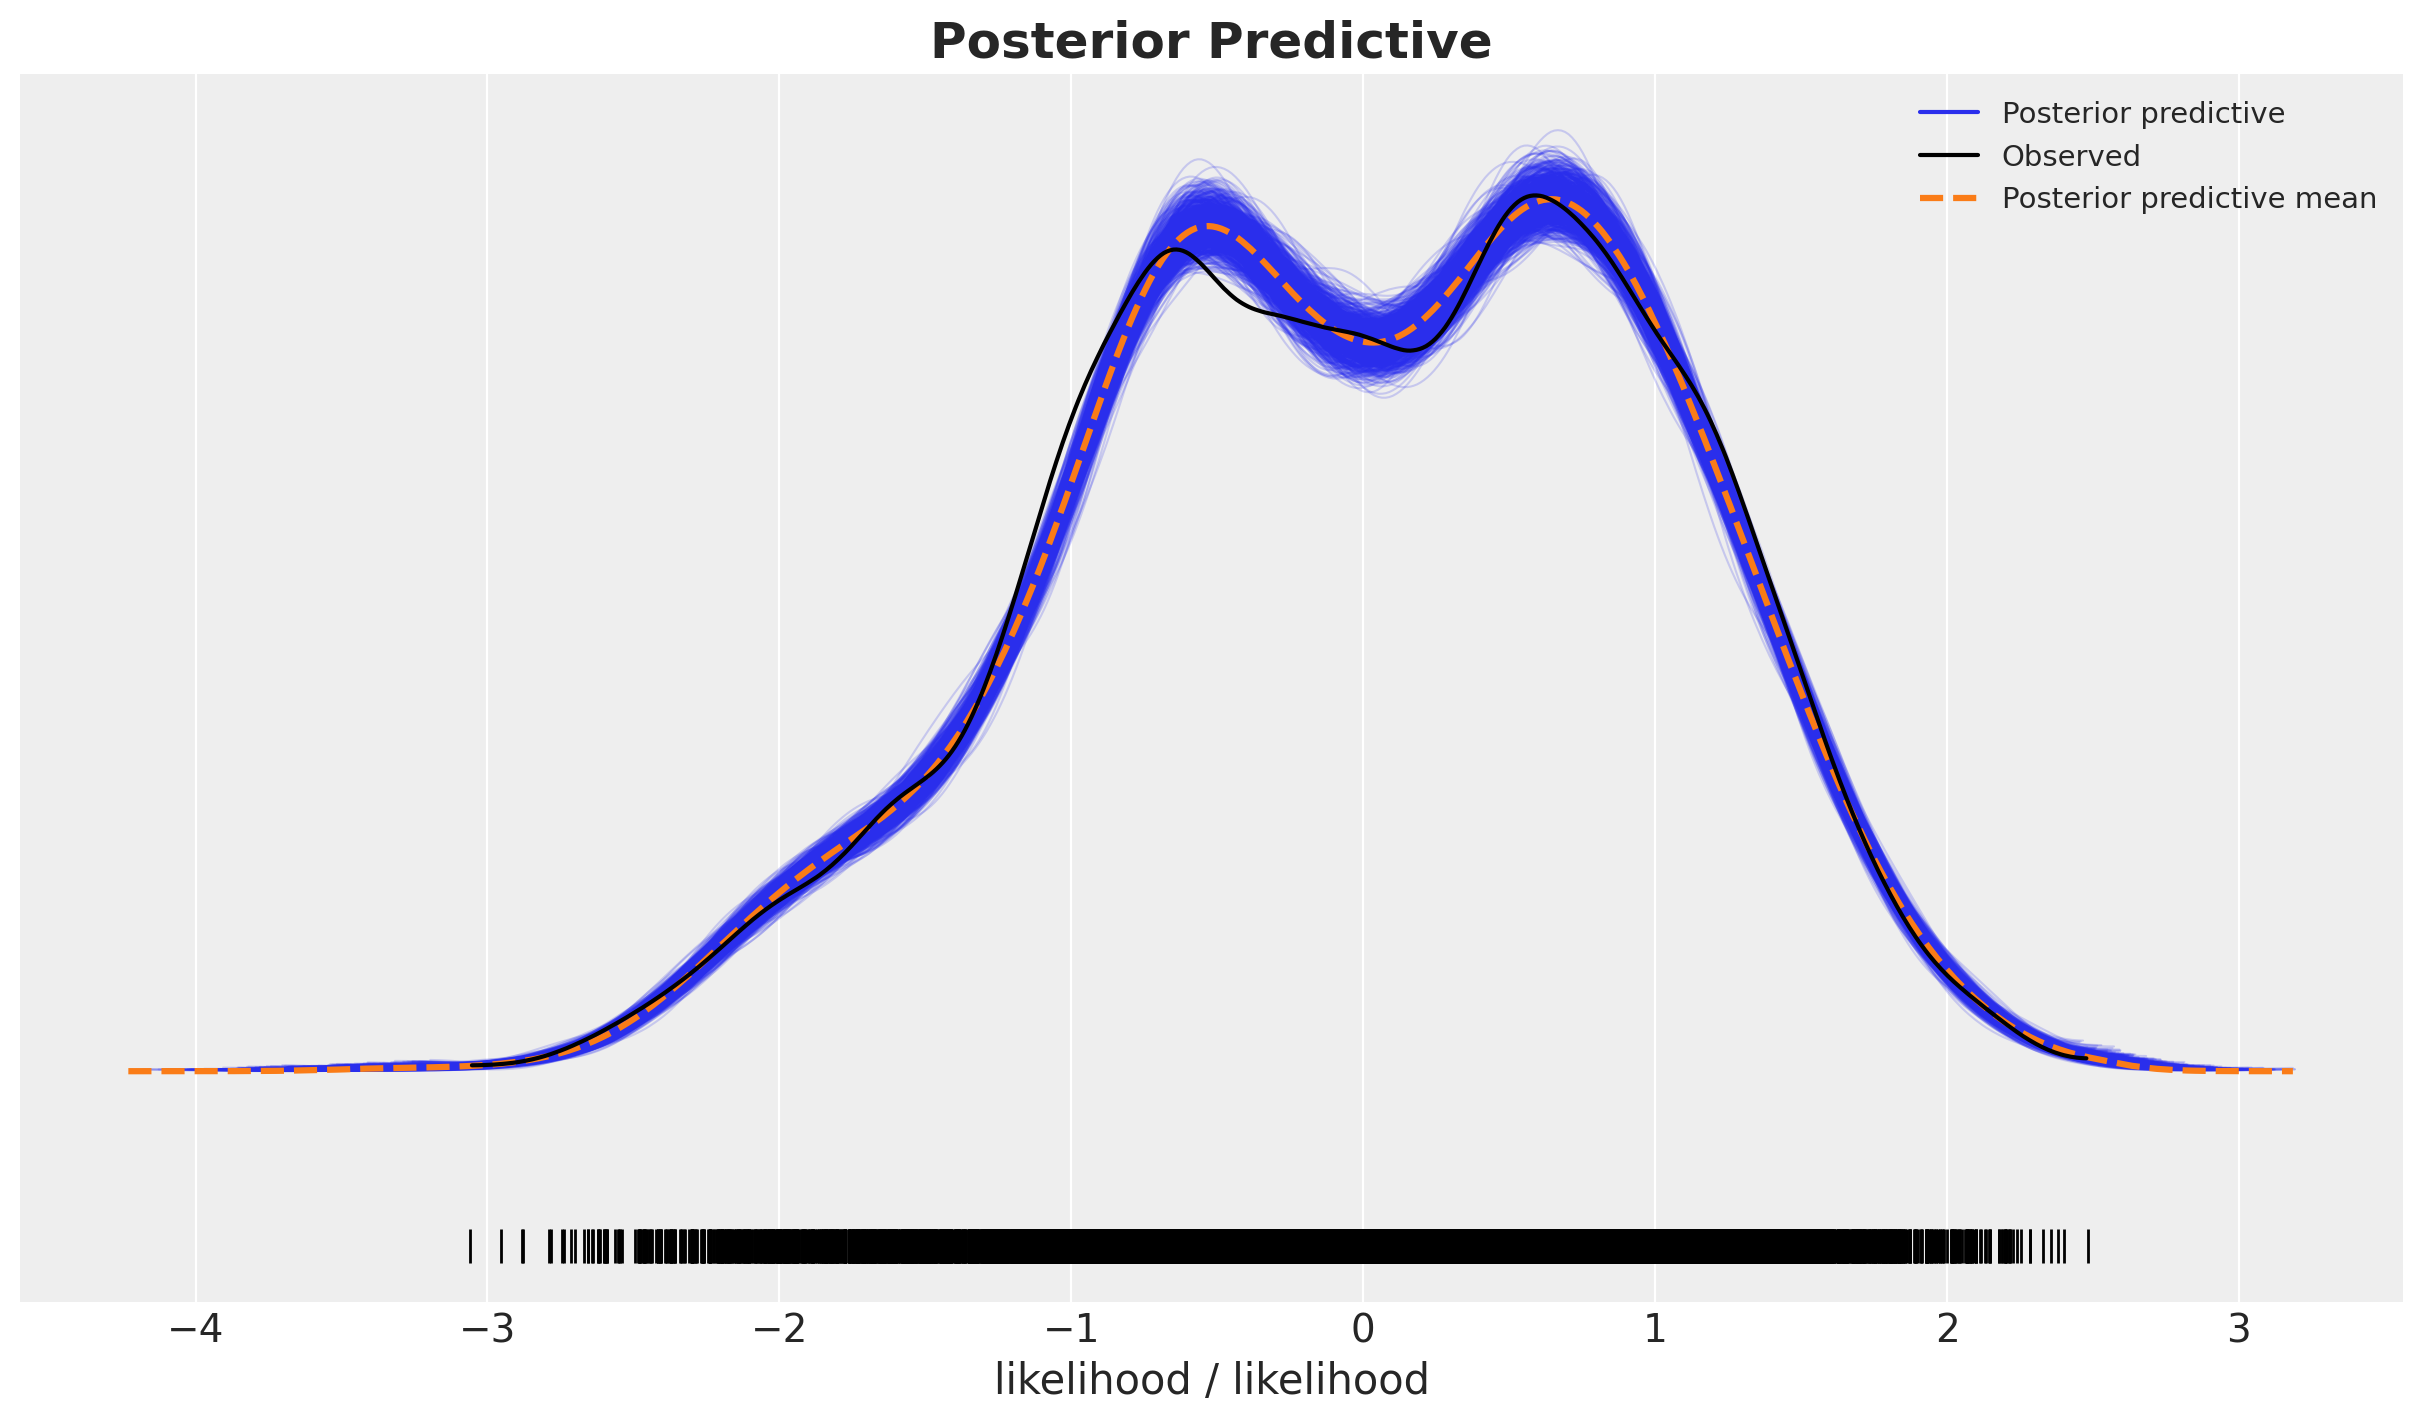

In [28]:
fig, ax = plt.subplots()
az.plot_ppc(
    data=posterior_predictive,
    num_pp_samples=1_000,
    observed_rug=True,
    random_seed=seed,
    ax=ax,
)
ax.set_title(label="Posterior Predictive", fontsize=18, fontweight="bold")